In [91]:
import matplotlib.dates as mdates
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss
from matplotlib.ticker import FuncFormatter
from pandas.plotting import scatter_matrix
from scipy.stats import shapiro
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Data Loading

In [92]:
df = pd.read_csv('no_outlier.csv')
df.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Data Cleaning

### To check the total of data

In [93]:
df.shape[0]

541906

### Check the total of null value of each variable

In [94]:
df.isnull().sum()

index               0
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### Check the unique of the description and stockcode. Because they are realated one stockcode only have one description     

In [95]:
a = df['StockCode'].nunique()
b = df['Description'].nunique()
print(a,b)

4070 4223


### Replace the description existing description by the StockCode

In [96]:
# Create a mapping of StockCode to the most common Description
stockcode_description_map = df.groupby('StockCode')['Description'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).to_dict()

# Fill missing Description values based on the StockCode
df['Description'] = df.apply(
    lambda row: stockcode_description_map[row['StockCode']] if pd.isnull(row['Description']) else row['Description'],
    axis=1
)



### Select random null value that replace with the same stockcode data

<div style="width: 500px; height: 100px;">
  <img src="prove.png" alt="Multi-Layer">
</div>

In [97]:
specific_index = 1971  # Replace with the actual index you want to display

# Display the row with the specified index
row = df.loc[specific_index]
print(row)

index                                     1971
InvoiceNo                               536546
StockCode                                22145
Description    CHRISTMAS CRAFT HEART STOCKING 
Quantity                                     1
InvoiceDate                    12/1/2010 14:33
UnitPrice                                  0.0
CustomerID                                 NaN
Country                         United Kingdom
Name: 1971, dtype: object


### Check null value remaining

In [98]:
# 112 missing values ​​description does not exist 
df.isnull().sum()

index               0
InvoiceNo           0
StockCode           0
Description       112
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### Check the contribution of the customer id in the dataset 

In [99]:
# Assuming `dataset` is your DataFrame
column_name = 'CustomerID'

# Calculate total missing values for the specified column
total_missing_column = df[column_name].isna().sum()

# Calculate percentage of missing values for the specified column
percent_missing_column = (total_missing_column / df[column_name].shape[0]) * 100

print("Total number of missing values in column '{}': {}".format(column_name, total_missing_column))
print("Percentage of missing values in column '{}': {:.2f}%".format(column_name, percent_missing_column))


Total number of missing values in column 'CustomerID': 135080
Percentage of missing values in column 'CustomerID': 24.93%


### Drop the null value in column description and customer id 

In [100]:
df = df.dropna(subset=['Description','CustomerID'])

In [101]:
df.isnull().sum()

index          0
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [102]:
def detect_outliers(df):
    outlier_summary = {}
    
    for column in df.select_dtypes(include=['number']).columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        
        if not outliers.empty:
            outlier_summary[column] = outliers
    
    return outlier_summary

# Get outliers for all numerical columns
outliers_summary = detect_outliers(df)

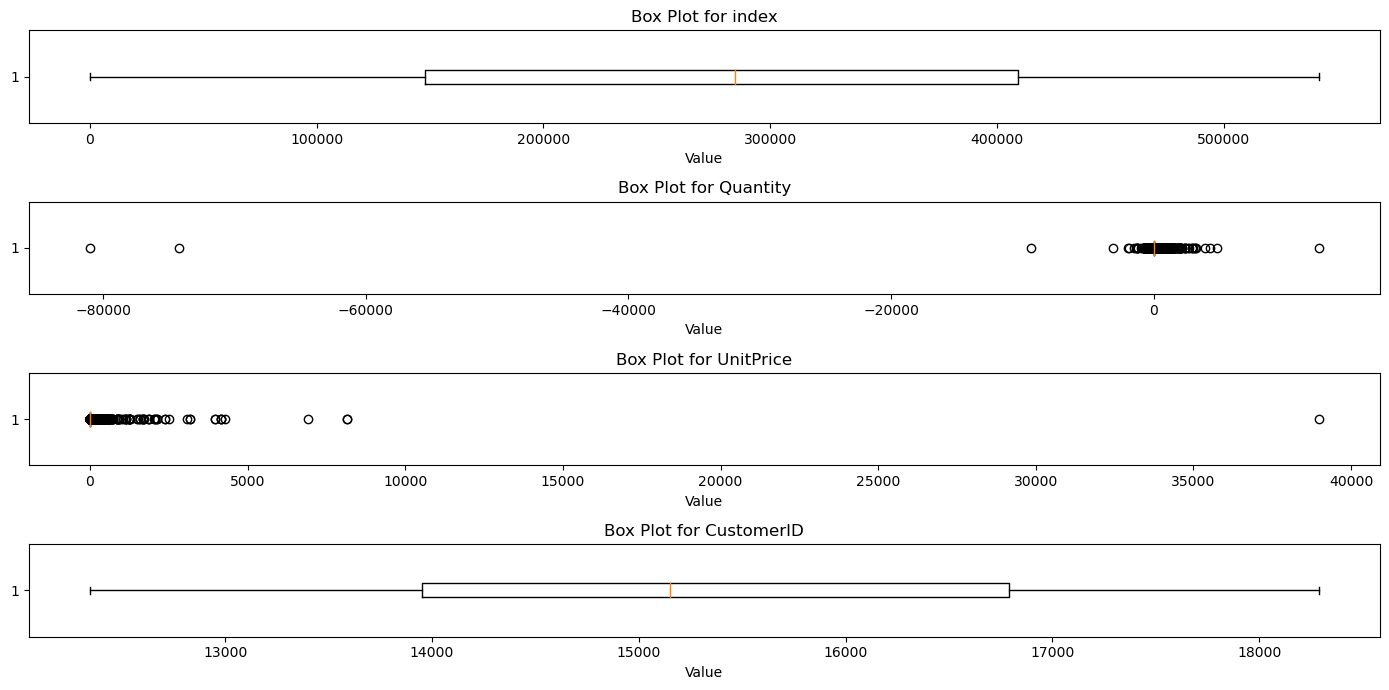

In [103]:
# Create box plots for each numerical column
plt.figure(figsize=(14, 7))
for i, column in enumerate(df.select_dtypes(include=['number']).columns, start=1):
    plt.subplot(len(df.select_dtypes(include=['number']).columns), 1, i)
    plt.boxplot(df[column], vert=False)
    plt.title(f'Box Plot for {column}')
    plt.xlabel('Value')

plt.tight_layout()
plt.show()


In [104]:
# Drop rows where 'Quantity' is negative
df = df[df['Quantity'] > 0]

# EDA

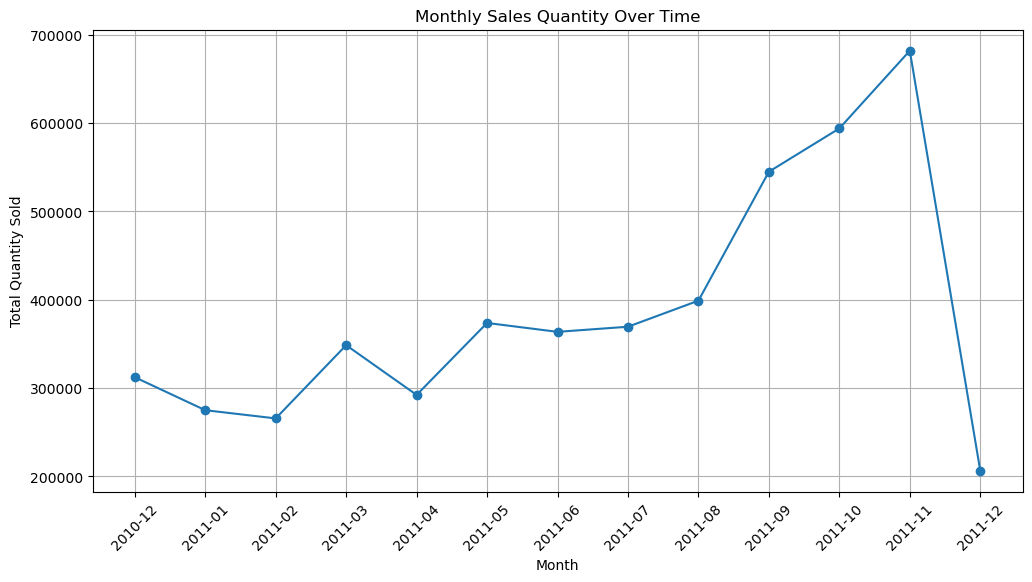

In [105]:
# Assuming your data is in a DataFrame named 'df'
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create a 'Month' column that combines Year and Month
df['Month'] = df['InvoiceDate'].dt.strftime('%Y-%m')

# Group by 'Month' and sum the 'Quantity' or 'UnitPrice' * 'Quantity' for revenue
monthly_sales = df.groupby('Month').agg({'Quantity': 'sum'}).reset_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['Month'], monthly_sales['Quantity'], marker='o')
plt.xticks(rotation=45)
plt.title('Monthly Sales Quantity Over Time')
plt.xlabel('Month')
plt.ylabel('Total Quantity Sold')
plt.grid(True)
plt.show()


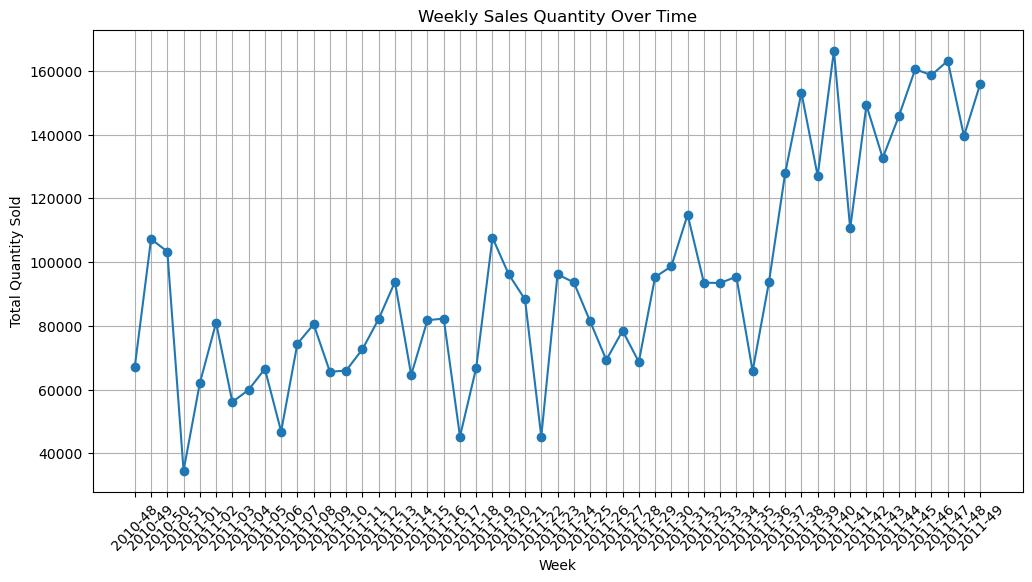

In [106]:
# Assuming your data is in a DataFrame named 'df'
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create a 'Week' column that combines Year and Week number
df['Week'] = df['InvoiceDate'].dt.strftime('%Y-%U')

# Group by 'Week' and sum the 'Quantity' or 'UnitPrice' * 'Quantity' for revenue
weekly_sales = df.groupby('Week').agg({'Quantity': 'sum'}).reset_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales['Week'], weekly_sales['Quantity'], marker='o')
plt.xticks(rotation=45)
plt.title('Weekly Sales Quantity Over Time')
plt.xlabel('Week')
plt.ylabel('Total Quantity Sold')
plt.grid(True)
plt.show()


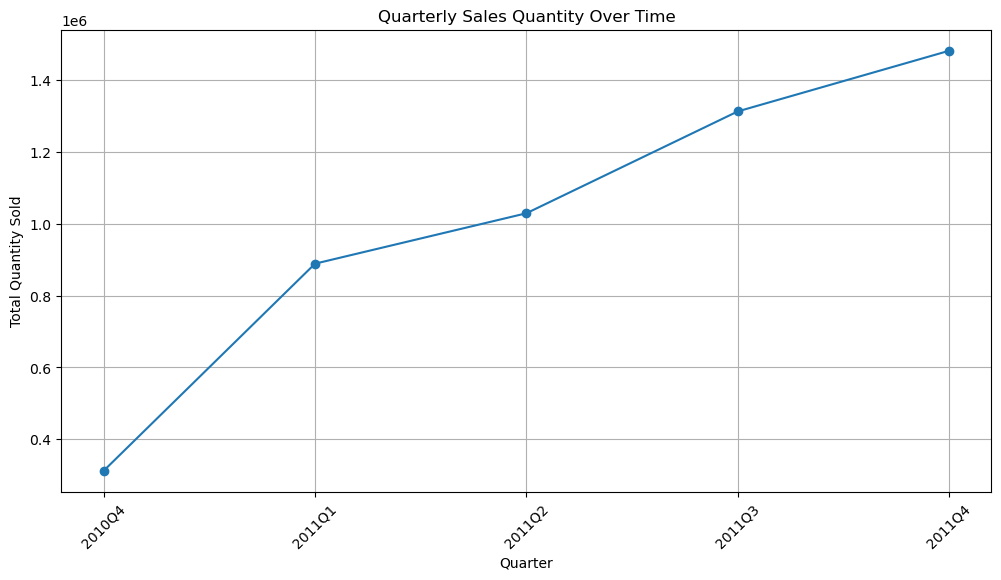

In [107]:
# Assuming your data is in a DataFrame named 'df'
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create a 'Quarter' column that combines Year and Quarter
df['Quarter'] = df['InvoiceDate'].dt.to_period('Q')

# Group by 'Quarter' and sum the 'Quantity'
quarterly_sales = df.groupby('Quarter').agg({'Quantity': 'sum'}).reset_index()

# Convert 'Quarter' to a string format for plotting
quarterly_sales['Quarter'] = quarterly_sales['Quarter'].astype(str)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(quarterly_sales['Quarter'], quarterly_sales['Quantity'], marker='o')
plt.xticks(rotation=45)
plt.title('Quarterly Sales Quantity Over Time')
plt.xlabel('Quarter')
plt.ylabel('Total Quantity Sold')
plt.grid(True)
plt.show()


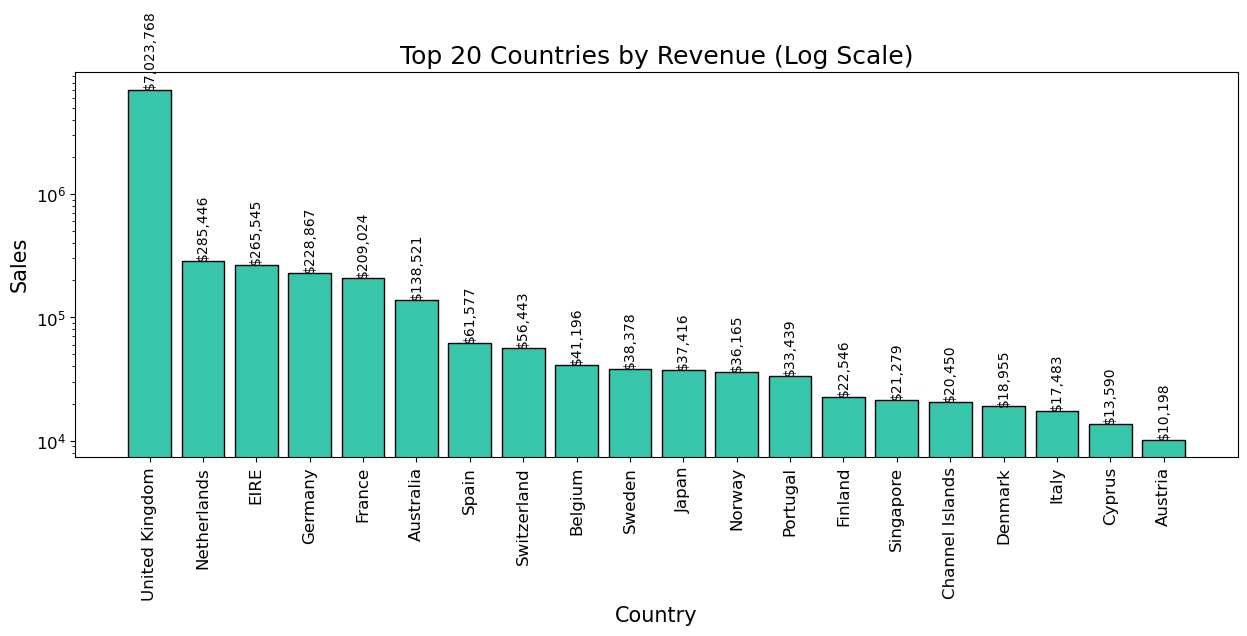

In [108]:
# Calculate the total revenue for each country
df['Sales'] = df['UnitPrice'] * df['Quantity']
country_revenue = df.groupby('Country').agg({'Sales': 'sum'}).reset_index()

# Sort by Revenue and get the top 20 countries
top_country = country_revenue.sort_values(by='Sales', ascending=False).head(20)

# Plotting all countries in one graph with a logarithmic scale
plt.figure(figsize=(15, 5))
plt.title('Top 20 Countries by Revenue (Log Scale)', fontsize=18)
bars = plt.bar(top_country['Country'], top_country['Sales'], color='#37C6AB', edgecolor='black', linewidth=1)
plt.xlabel('Country', fontsize=15)
plt.ylabel('Sales', fontsize=15)
plt.yscale('log')  # Apply log scale to better visualize smaller values
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)

# Add the revenue values as text annotations on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'${int(yval):,}', 
             ha='center', va='bottom', fontsize=10, rotation=90)

plt.show()


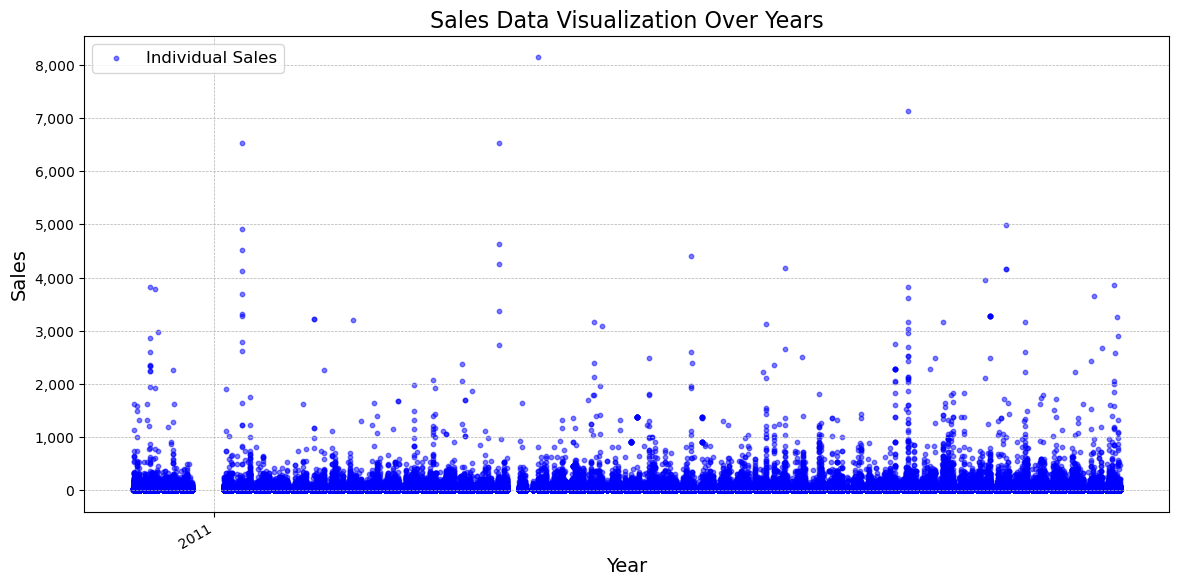

In [109]:
# Convert 'InvoiceDate' to datetime if not already
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Set the figure size
plt.figure(figsize=(14, 7))

# Create a scatter plot for all individual sales
plt.scatter(
    df['InvoiceDate'],  # Use 'InvoiceDate' for dates on the x-axis
    df['Sales'],  # Sales values on the y-axis
    color='blue',  # Point color
    marker='o',  # Point shape
    s=10,  # Size of the points
    alpha=0.5  # Transparency of the points
)

# Improve x-axis formatting to emphasize years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Show a tick for every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format the date display as Year only
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

# Set y-axis formatter to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))  # Format numbers with commas

# Adding grid, labels, and title for clarity
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title('Sales Data Visualization Over Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Sales', fontsize=14)

# Display the legend
plt.legend(['Individual Sales'], loc='upper left', fontsize=12)

# Show the plot
plt.show()


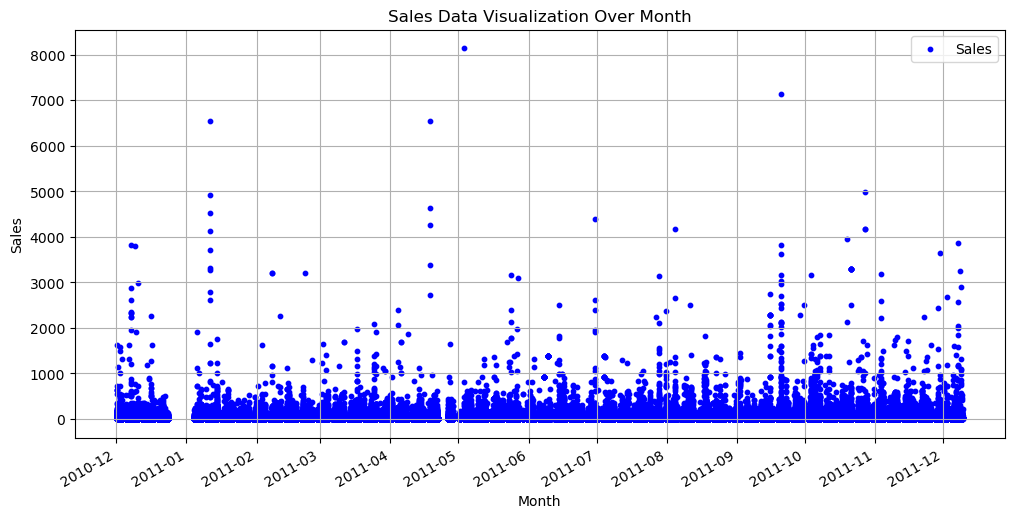

In [110]:
# Ensure 'InvoiceDate' is in datetime format if not already
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Set the figure size
plt.figure(figsize=(12, 6))

# Create a scatter plot for all sales
plt.scatter(
    df['InvoiceDate'],  # Use 'InvoiceDate' for dates on the x-axis
    df['Sales'],  # Use 'Sales' for sales values on the y-axis
    label='Sales', marker='o', s=10, color='blue'  # Basic configuration for the plot
)

# Improve x-axis formatting
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Show a tick for every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format the date display
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

# Set labels, title, legend, and grid
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales Data Visualization Over Month')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


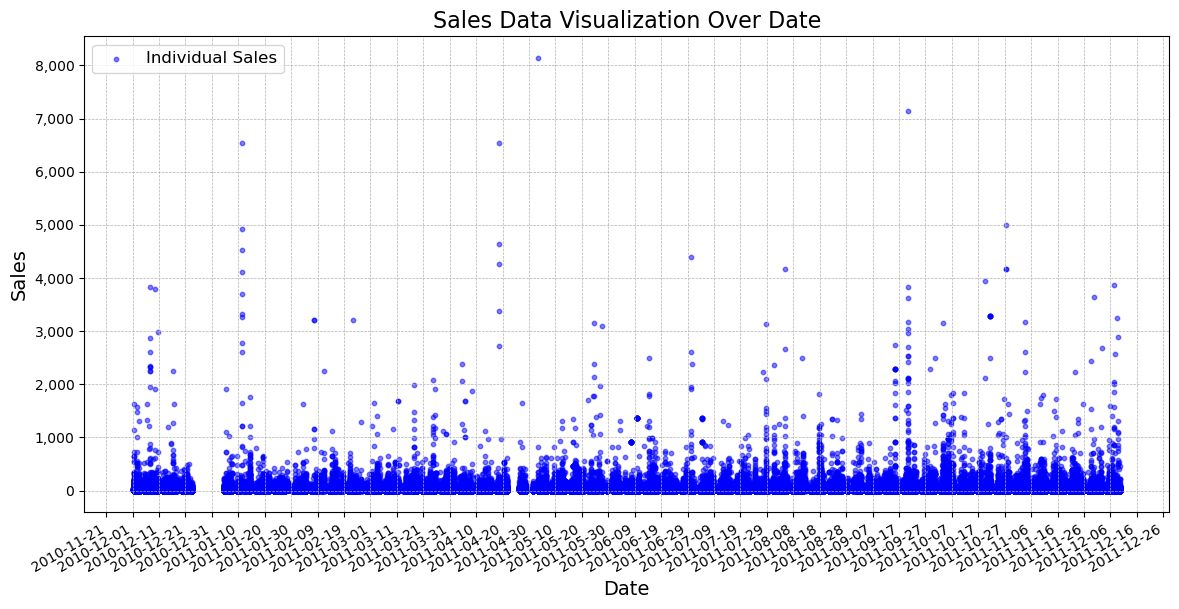

In [111]:
# Ensure 'InvoiceDate' is in datetime format if not already
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Set the figure size
plt.figure(figsize=(14, 7))

# Create a scatter plot for all individual sales
plt.scatter(
    df['InvoiceDate'],  # Use 'InvoiceDate' for dates on the x-axis
    df['Sales'],  # Sales values on the y-axis
    color='blue',  # Point color
    marker='o',  # Point shape
    s=10,  # Size of the points
    alpha=0.5  # Transparency of the points
)

# Improve x-axis formatting to show more detailed date information
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))  # Show a tick for every 10 days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the date display as Year-Month-Day
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

# Set y-axis formatter to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))  # Format numbers with commas

# Adding grid, labels, and title for clarity
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title('Sales Data Visualization Over Date', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales', fontsize=14)

# Display the legend
plt.legend(['Individual Sales'], loc='upper left', fontsize=12)

# Show the plot
plt.show()


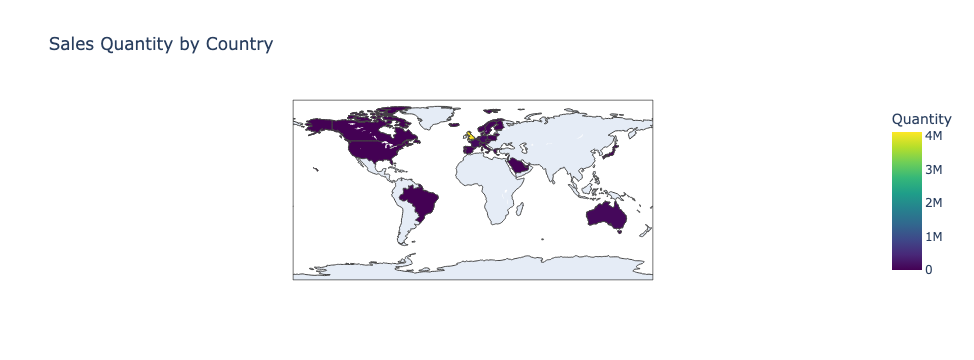

In [112]:
country_sales = df.groupby('Country')['Quantity'].sum().reset_index()

# Create a map visualization (requires ISO country codes; some preprocessing might be needed)
fig = px.choropleth(country_sales, locations="Country",
                    locationmode='country names',
                    color="Quantity",
                    hover_name="Country",
                    color_continuous_scale="Viridis",
                    title="Sales Quantity by Country")
fig.show()


In [113]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour
df['IsWeekend'] = df['DayOfWeek'] >= 5
df.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,Week,Quarter,Sales,Year,Day,DayOfWeek,Hour,IsWeekend
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12,2010-48,2010Q4,15.30,2010,1,2,8,False
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010-48,2010Q4,20.34,2010,1,2,8,False
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12,2010-48,2010Q4,22.00,2010,1,2,8,False
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010-48,2010Q4,20.34,2010,1,2,8,False
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010-48,2010Q4,20.34,2010,1,2,8,False


In [114]:
# Drop rows where 'Sales' column has a value of 0 in your 'df' DataFrame
df = df[df['Sales'] != 0]

# Check if there are any rows with Sales = 0 remaining
print(f"Rows with Sales = 0: {(df['Sales'] == 0).sum()}")  # Should return 0


Rows with Sales = 0: 0


In [115]:
# Label Encoding StockCode
le_stockcode = LabelEncoder()
df['StockCode_Encoded'] = le_stockcode.fit_transform(df['StockCode'])

# Label Encoding Country
le_country = LabelEncoder()
df['Country_Encoded'] = le_country.fit_transform(df['Country'])

# Convert IsWeekend to binary encoding
df['IsWeekend_Encoded'] = df['IsWeekend'].astype(int)


df.head(5)


,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,...,Quarter,Sales,Year,Day,DayOfWeek,Hour,IsWeekend,StockCode_Encoded,Country_Encoded,IsWeekend_Encoded
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12,...,2010Q4,15.30,2010,1,2,8,False,3232,35,0
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,...,2010Q4,20.34,2010,1,2,8,False,2642,35,0
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12,...,2010Q4,22.00,2010,1,2,8,False,2846,35,0
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,...,2010Q4,20.34,2010,1,2,8,False,2794,35,0
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,...,2010Q4,20.34,2010,1,2,8,False,2793,35,0


In [116]:
# Display the data types of each column in the DataFrame
print(df.dtypes)


index                         int64
InvoiceNo                    object
StockCode                    object
Description                  object
Quantity                      int64
InvoiceDate          datetime64[ns]
UnitPrice                   float64
CustomerID                  float64
Country                      object
Month                         int64
Week                         object
Quarter               period[Q-DEC]
Sales                       float64
Year                          int64
Day                           int64
DayOfWeek                     int64
Hour                          int64
IsWeekend                      bool
StockCode_Encoded             int64
Country_Encoded               int64
IsWeekend_Encoded             int64
dtype: object


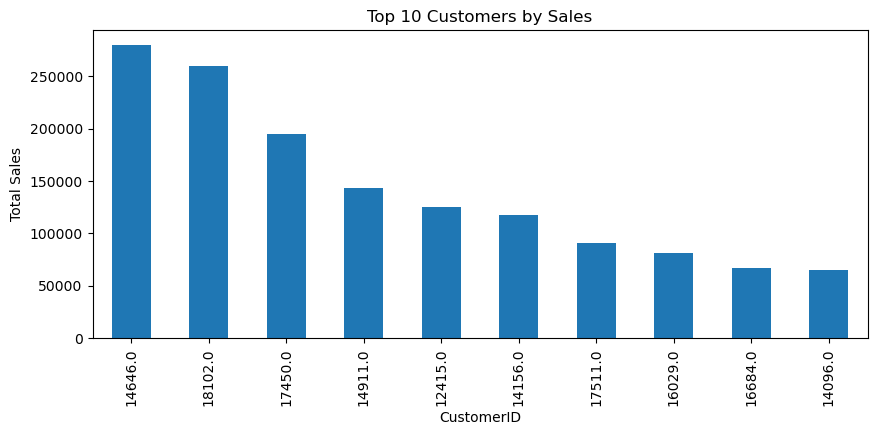

In [117]:
# Analyzing customer behavior
customer_sales = df.groupby('CustomerID')['Sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 4))
customer_sales.head(10).plot(kind='bar')  # Top 10 customers by sales
plt.title('Top 10 Customers by Sales')
plt.xlabel('CustomerID')
plt.ylabel('Total Sales')
plt.show()


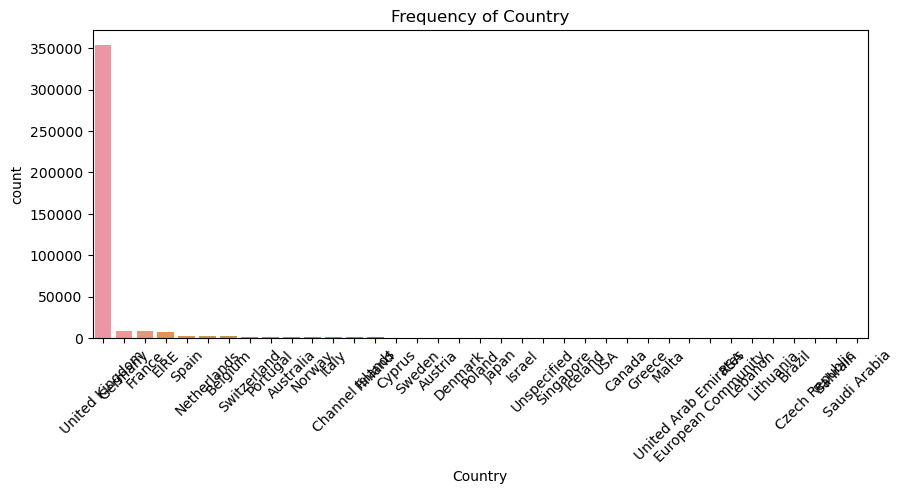

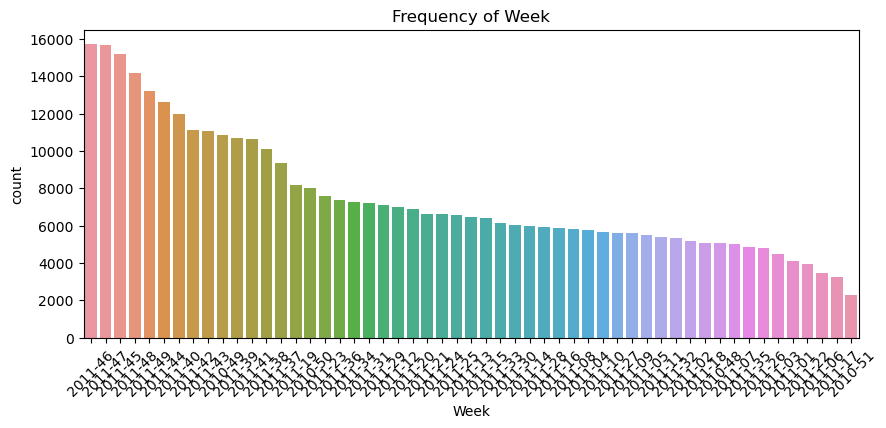

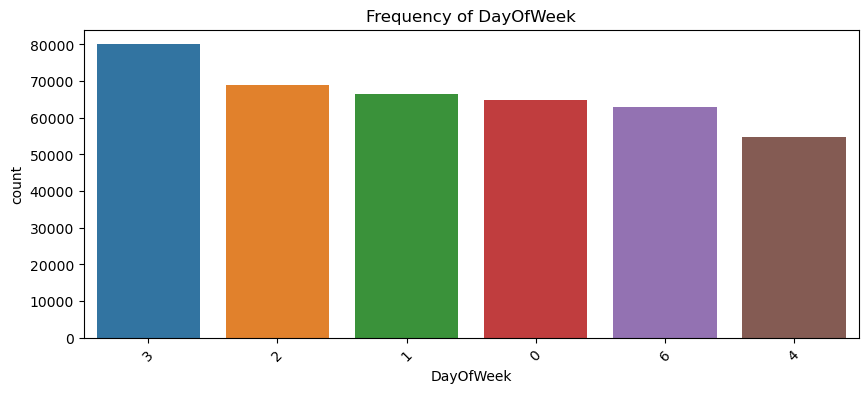

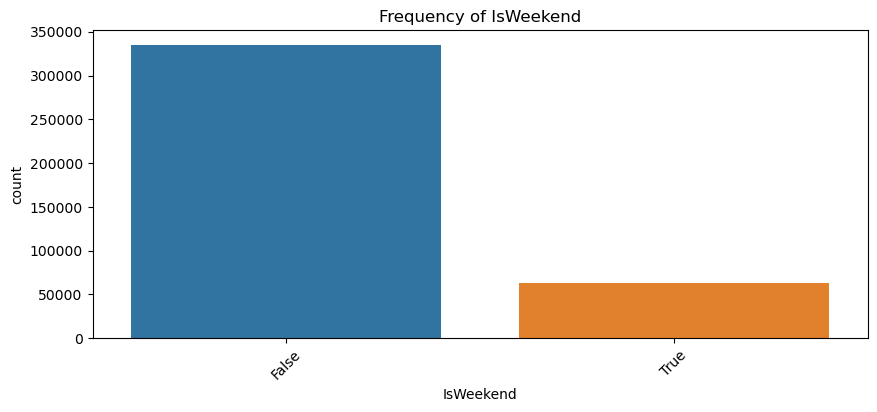

In [118]:
# Frequency of categorical features
categorical_features = ['Country', 'Week', 'DayOfWeek', 'IsWeekend']
for feature in categorical_features:
    plt.figure(figsize=(10, 4))
    chart = sns.countplot(x=feature, data=df, order = df[feature].value_counts().index)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    plt.title(f'Frequency of {feature}')
    plt.show()


In [119]:
# Convert InvoiceDate to a Unix timestamp
df['InvoiceTimestamp'] = df['InvoiceDate'].apply(lambda x: x.timestamp())


In [120]:
# Display basic statistics and the first few rows of the dataset
print(df.describe())
print(df.head())


               index       Quantity      UnitPrice     CustomerID  \
count  397881.000000  397881.000000  397881.000000  397881.000000   
mean   278463.020707      12.598093       3.114871   15294.428462   
std    152770.451127      42.885991      22.074187    1713.140641   
min         0.000000       1.000000       0.001000   12347.000000   
25%    148334.000000       2.000000       1.250000   13969.000000   
50%    284903.000000       6.000000       1.950000   15159.000000   
75%    410074.000000      12.000000       3.750000   16795.000000   
max    541908.000000    4800.000000    8142.750000   18287.000000   

               Month          Sales           Year            Day  \
count  397881.000000  397881.000000  397881.000000  397881.000000   
mean        7.612485      21.681821    2010.934259      15.042206   
std         3.416508      73.719532       0.247829       8.653769   
min         1.000000       0.001000    2010.000000       1.000000   
25%         5.000000       4.6800

/Users/yapjh/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



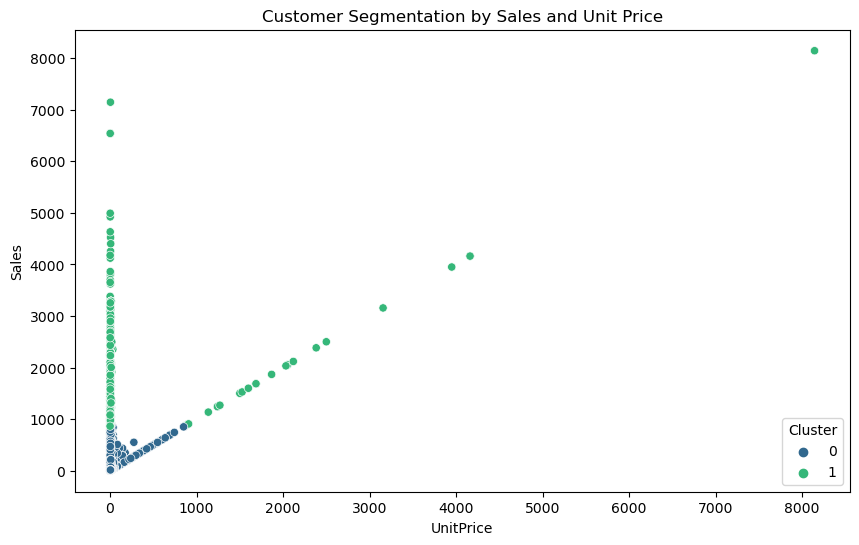

In [121]:
# Example: K-means for customer segmentation
features = df[['Sales', 'Quantity', 'UnitPrice']]
kmeans = KMeans(n_clusters=2, random_state=0).fit(features)
df['Cluster'] = kmeans.labels_

# Visualizing clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='UnitPrice', y='Sales', hue='Cluster', data=df, palette='viridis')
plt.title('Customer Segmentation by Sales and Unit Price')
plt.show()


           term  occurrences
1574        set        46825
110         bag        37774
1462        red        32156
863       heart        29342
1478  retrospot        26336
1904    vintage        25579
542      design        23519
1343       pink        20361
392   christmas        19057
231         box        17893
1933      white        16156
287        cake        16121
1111      metal        15840
954       jumbo        15482
1063      lunch        14940
201        blue        14321
1025      light        13719
851     hanging        12839
1610       sign        12760
887      holder        12556


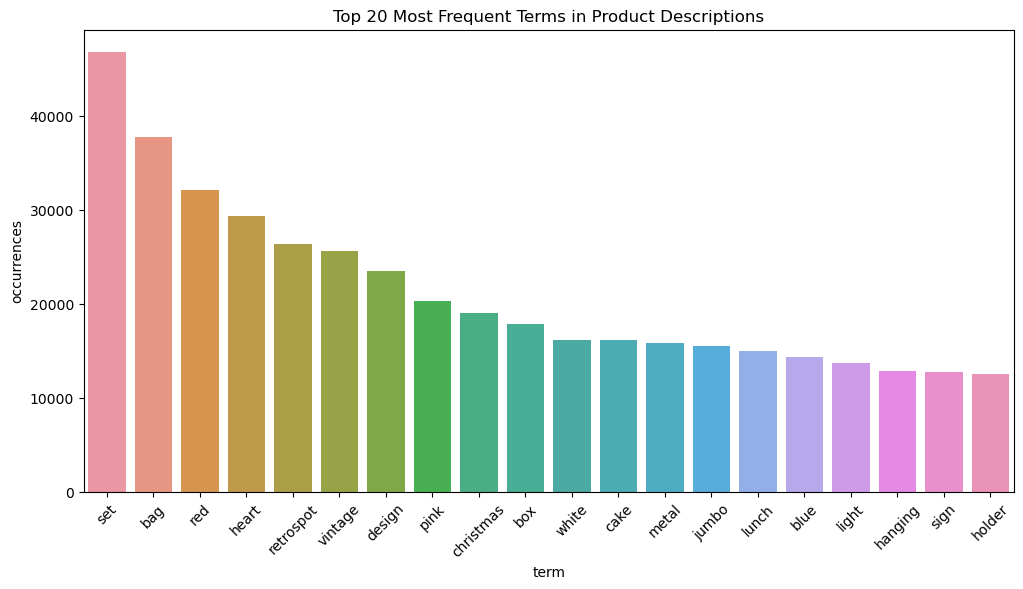

In [122]:
# Text analysis of descriptions
vect = CountVectorizer(stop_words='english')
X = vect.fit_transform(df['Description'].dropna())

# Summing word occurrences
word_counts = np.asarray(X.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': vect.get_feature_names_out(), 'occurrences': word_counts})
top_terms = counts_df.sort_values(by='occurrences', ascending=False).head(20)
print(top_terms)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='term', y='occurrences', data=top_terms)
plt.xticks(rotation=45)
plt.title('Top 20 Most Frequent Terms in Product Descriptions')
plt.show()


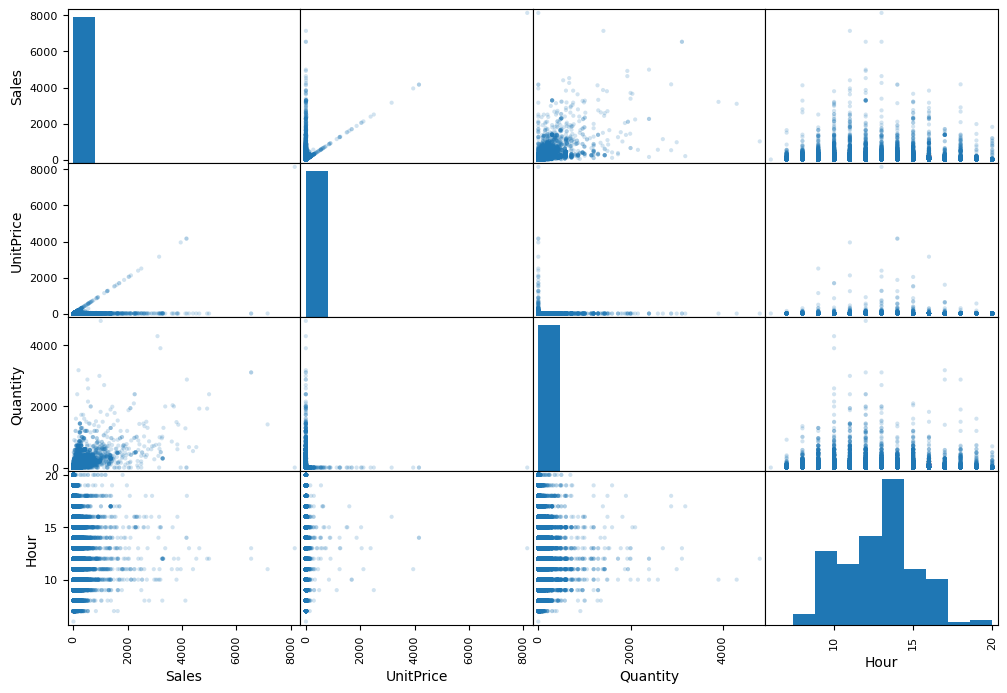

In [123]:
# Scatter plot matrix with different variables
attributes = ['Sales', 'UnitPrice', 'Quantity', 'Hour']
scatter_matrix(df[attributes], figsize=(12, 8), alpha=0.2)
plt.show()

# Advanced: Using pair grid for detailed control
#g = sns.PairGrid(df[attributes])
#g.map_upper(sns.scatterplot)
#g.map_lower(sns.kdeplot, colors="C0")
#g.map_diag(sns.histplot, kde_kws={"color": "k"})
#plt.show()


IsWeekend  False  True 
DayOfWeek              
0          64893      0
1          66472      0
2          68885      0
3          80035      0
4          54823      0
6              0  62773


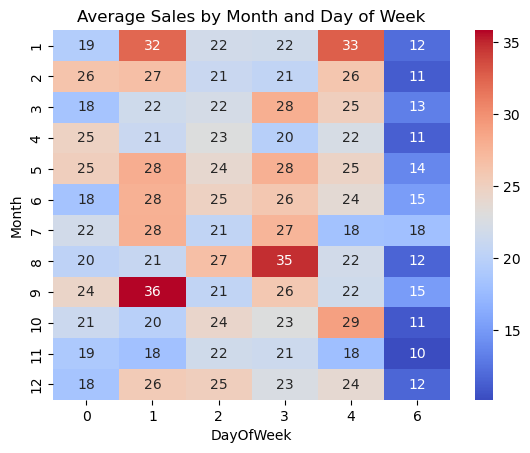

In [124]:
# Cross-tabulation of Weekday vs. IsWeekend
weekend_cross = pd.crosstab(index=df['DayOfWeek'], columns=df['IsWeekend'])
print(weekend_cross)

# Pivot table for average sales by month and day
pivot_table = df.pivot_table(values='Sales', index='Month', columns='DayOfWeek', aggfunc='mean')
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".0f")
plt.title('Average Sales by Month and Day of Week')
plt.show()


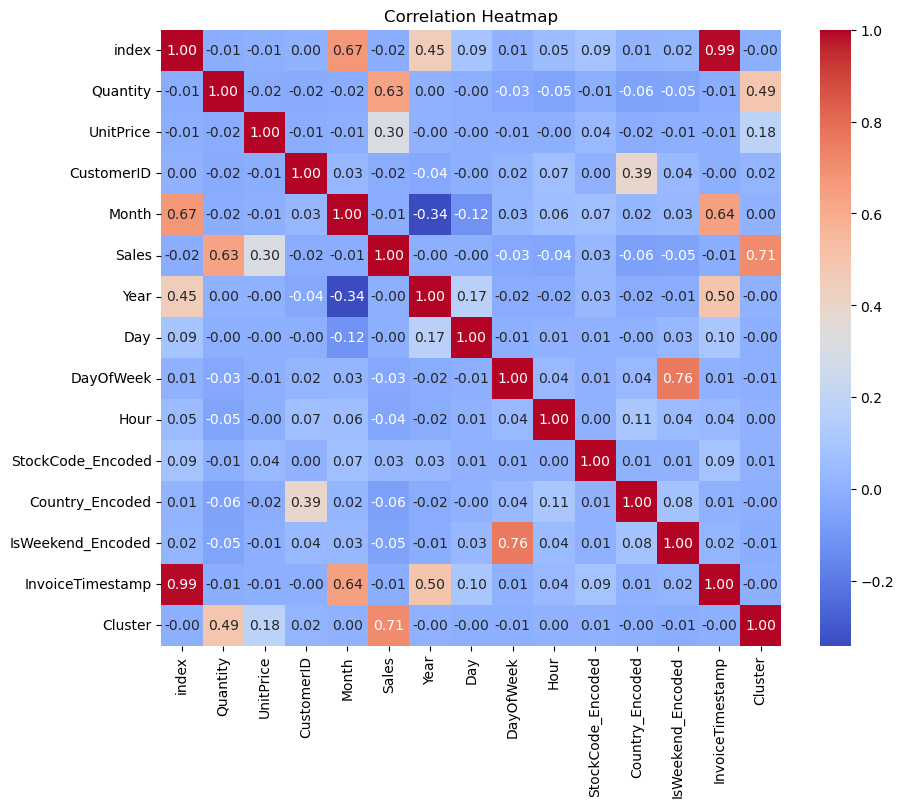

In [125]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])

# Create a correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


# Check feature and stationary

count    397881.000000
mean         21.681821
std          73.719532
min           0.001000
25%           4.680000
50%          11.800000
75%          19.800000
max        8142.750000
Name: Sales, dtype: float64
15.00      20082
17.70       9174
16.50       8490
10.20       8028
19.80       7625
           ...  
24.38          1
1305.60        1
277.92         1
481.50         1
66.36          1
Name: Sales, Length: 2936, dtype: int64


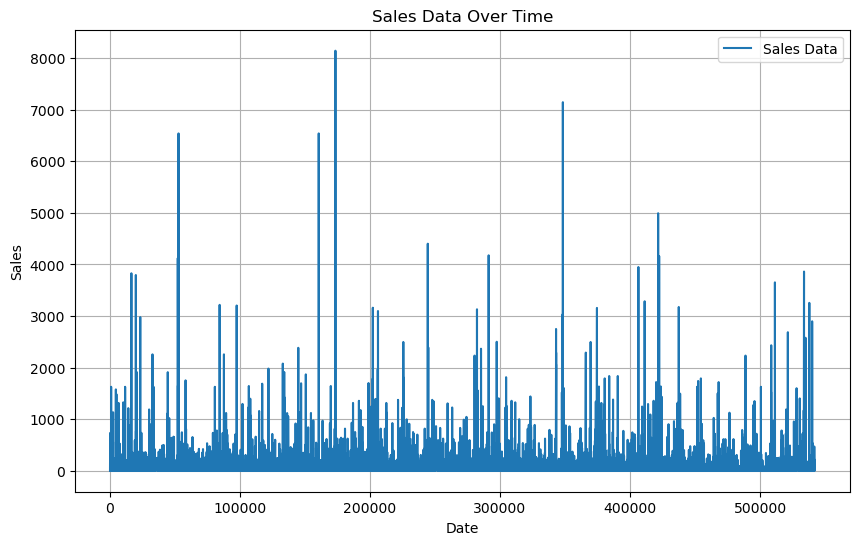

In [126]:
print(df['Sales'].describe())
print(df['Sales'].value_counts())

# Plotting sales data
plt.figure(figsize=(10, 6))
plt.plot(df['Sales'], label='Sales Data')
plt.title('Sales Data Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


In [127]:
# Shapiro-Wilk Test for normality on Sales data
#Testing whether data distributions differ significantly from a normal distribution can impact your choice of statistical tests and data modeling approaches.

stat, p = shapiro(df['Sales'].dropna().sample(500))  # Sampling due to Shapiro-Wilk limitations
print('Shapiro-Wilk Test statistics=%.3f, p-value=%.3f' % (stat, p))
if p > 0.05:
    print('Sample looks Gaussian (normal distribution)')
else:
    print('Sample does not look Gaussian (normal distribution)')


Shapiro-Wilk Test statistics=0.288, p-value=0.000
Sample does not look Gaussian (normal distribution)


In [128]:
# OLS Regression for predicting Sales based on other factors
X = df[['Quantity', 'UnitPrice']]  # Predictor variables
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = df['Sales']

model = sm.OLS(y, X).fit()
summary = model.summary()
print(summary)


                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                 1.996e+05
Date:                Mon, 09 Sep 2024   Prob (F-statistic):               0.00
Time:                        03:24:25   Log-Likelihood:            -2.1373e+06
No. Observations:              397881   AIC:                         4.275e+06
Df Residuals:                  397878   BIC:                         4.275e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5540      0.087     52.401      0.0

In [129]:
df['Sales_log'] = np.log(df['Sales'] + 1)  # Adding 1 to avoid log(0) errors

# Run the KPSS test on the log-transformed data
kpss_result = kpss(df['Sales_log'].dropna(), regression='c')  # 'c' assumes constant
print('KPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])

if kpss_result[1] < 0.05:
    print("The log-transformed data is trend stationary")
else:
    print("The log-transformed data is not trend stationary")


KPSS Statistic: 5.422769156435119
p-value: 0.01
The log-transformed data is trend stationary


/var/folders/y_/qkxqbmxd0k5gnn8kshk68v640000gn/T/ipykernel_70760/1731030797.py:4: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




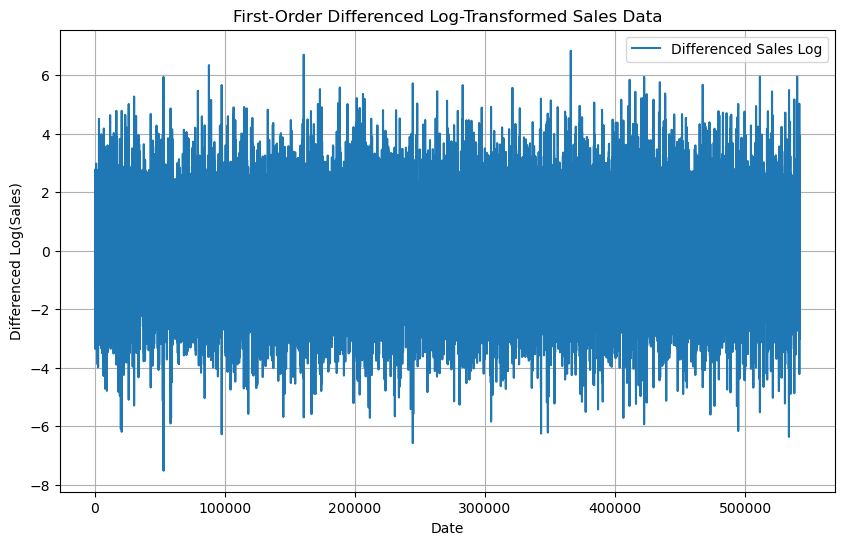

KPSS Statistic (differenced): 0.0015833189147262073
KPSS p-value (differenced): 0.1


/var/folders/y_/qkxqbmxd0k5gnn8kshk68v640000gn/T/ipykernel_70760/3259368770.py:17: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [130]:
# Log transformation and differencing
df['Sales_log'] = np.log(df['Sales'] + 1)
df['Sales_diff'] = df['Sales_log'].diff().dropna()


# Plot the differenced data
plt.figure(figsize=(10, 6))
plt.plot(df['Sales_diff'], label='Differenced Sales Log')
plt.title('First-Order Differenced Log-Transformed Sales Data')
plt.xlabel('Date')
plt.ylabel('Differenced Log(Sales)')
plt.legend()
plt.grid(True)
plt.show()

# Re-run the KPSS and ADF tests to check for stationarity
kpss_result_diff = kpss(df['Sales_diff'].dropna(), regression='c')
print('KPSS Statistic (differenced):', kpss_result_diff[0])
print('KPSS p-value (differenced):', kpss_result_diff[1])



In [131]:
# Apply seasonal differencing (e.g., period=12 for monthly data)
df['Sales_seasonal_diff'] = df['Sales_log'].diff(12).dropna()

# Re-run the stationarity tests on seasonally differenced data
kpss_seasonal = kpss(df['Sales_seasonal_diff'].dropna(), regression='c')

print(f'KPSS (seasonal differencing): Statistic = {kpss_seasonal[0]}, p-value = {kpss_seasonal[1]}')


KPSS (seasonal differencing): Statistic = 0.0005198227664954315, p-value = 0.1


/var/folders/y_/qkxqbmxd0k5gnn8kshk68v640000gn/T/ipykernel_70760/4193009209.py:5: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




# Split the dataset

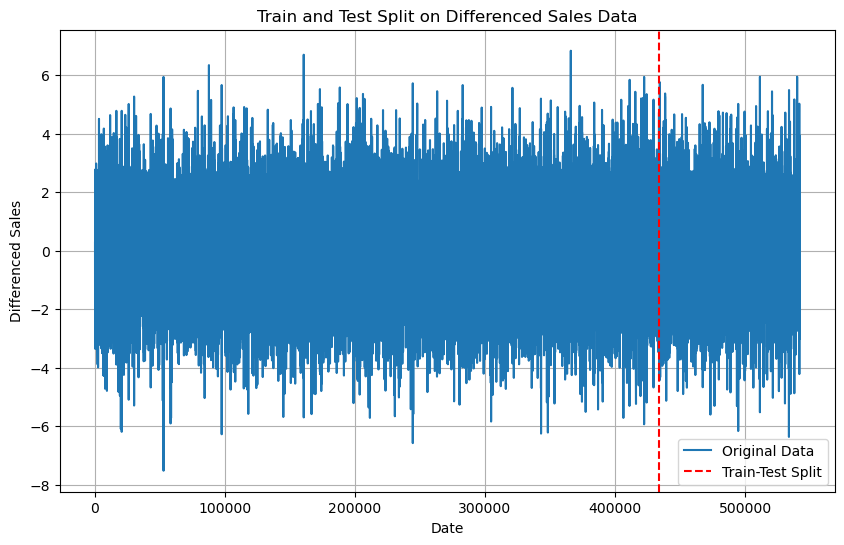

Train set size: 318304, Test set size: 79577


In [132]:
# Define the split point (e.g., 80% training and 20% testing)
split_point = int(len(df) * 0.8)

# Split into training and testing data
train_data = df['Sales_diff'].iloc[:split_point]  # Use the differenced data for stationarity
test_data = df['Sales_diff'].iloc[split_point:]

# Plot to visualize the split
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Sales_diff'], label='Original Data')
plt.axvline(x=df.index[split_point], color='red', linestyle='--', label='Train-Test Split')
plt.title('Train and Test Split on Differenced Sales Data')
plt.xlabel('Date')
plt.ylabel('Differenced Sales')
plt.legend()
plt.grid(True)
plt.show()

print(f'Train set size: {len(train_data)}, Test set size: {len(test_data)}')


# Model

In [133]:
# Load your DataFrame (assuming 'df' is already loaded and 'InvoiceDate' is a datetime column)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.set_index('InvoiceDate', inplace=True)

# Find the earliest date in your dataset
earliest_date = df.index.min()

# Create a new DataFrame starting from the earliest date
data = {
    'InvoiceDate': pd.date_range(start=earliest_date, periods=100, freq='D'),  # Start from the earliest date
    'Sales_diff': [100 + i * 5 for i in range(100)],  # Simulated sales data
    'UnitPrice': [10] * 100,  # Constant unit price
    'Country_Encoded': [0, 1, 0, 1] * 25  # Simulated country encoding
}
new_df = pd.DataFrame(data)
new_df['InvoiceDate'] = pd.to_datetime(new_df['InvoiceDate'])
new_df.set_index('InvoiceDate', inplace=True)
new_df['Month'] = new_df.index.month
new_df['DayOfWeek'] = new_df.index.dayofweek
new_df['IsWeekend'] = new_df['DayOfWeek'] >= 5

# Aggregate existing data to monthly
df_monthly = df.resample('M').agg({
    'Sales_diff': 'sum',
    'UnitPrice': 'mean',
    'Country_Encoded': 'mean'
}).reset_index()
df_monthly['Month'] = df_monthly['InvoiceDate'].dt.month
df_monthly['DayOfWeek'] = df_monthly['InvoiceDate'].dt.dayofweek
df_monthly['IsWeekend'] = df_monthly['DayOfWeek'] >= 5

### Linear Regression

In [134]:
# Prepare data for modeling
X = df_monthly[['Month', 'DayOfWeek', 'UnitPrice', 'IsWeekend', 'Country_Encoded']]
y = df_monthly['Sales_diff']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)


LinearRegression()

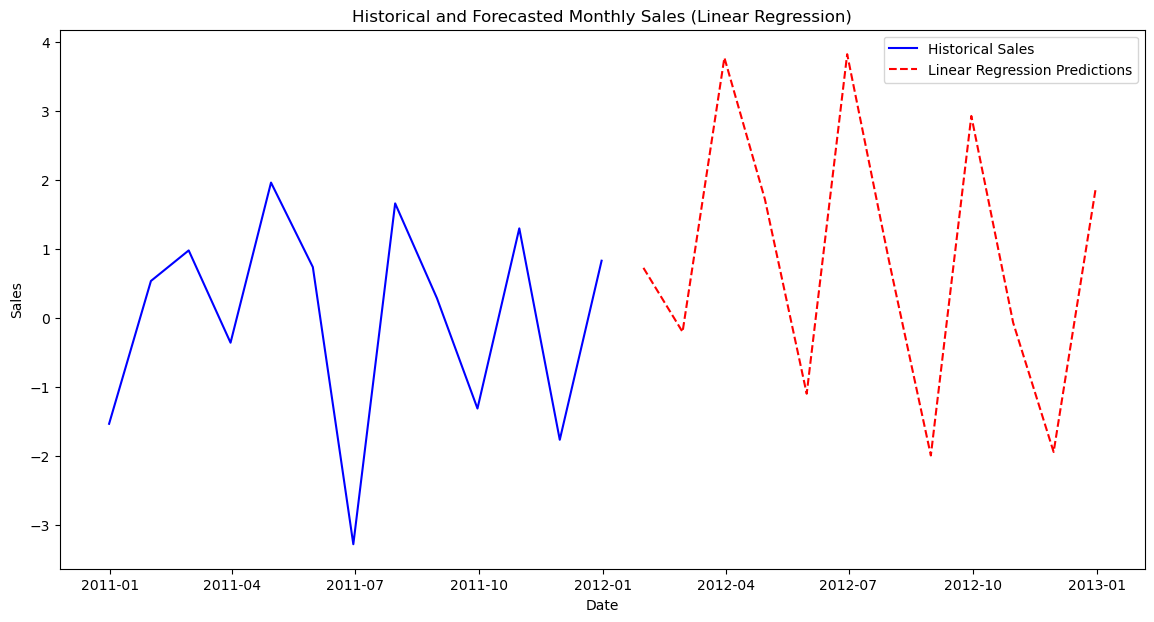

In [135]:
# Predict using the trained model
y_pred = lin_model.predict(X_test)

# Prepare the combined future and historical index for future dates
future_dates = pd.date_range(start=df_monthly['InvoiceDate'].max() + pd.DateOffset(months=1), periods=12, freq='M')
combined_data = pd.DataFrame(index=future_dates)
combined_data['Month'] = combined_data.index.month
combined_data['DayOfWeek'] = combined_data.index.dayofweek
combined_data['UnitPrice'] = df_monthly['UnitPrice'].mean()  # Assuming constant unit price
combined_data['IsWeekend'] = combined_data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
combined_data['Country_Encoded'] = df_monthly['Country_Encoded'].mode()[0]  # Most frequent value

# Generate predictions for the entire period
lin_sales_predictions = lin_model.predict(combined_data)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df_monthly['InvoiceDate'], y, label='Historical Sales', color='blue')
plt.plot(future_dates, lin_sales_predictions, label='Linear Regression Predictions', linestyle='--', color='red')
plt.title('Historical and Forecasted Monthly Sales (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [136]:
# Assuming new_df is your DataFrame and is already prepared with features
X = new_df[['Month', 'DayOfWeek', 'UnitPrice', 'IsWeekend', 'Country_Encoded']]  # Example features
y = new_df['Sales_diff']  # Target

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)


LinearRegression()

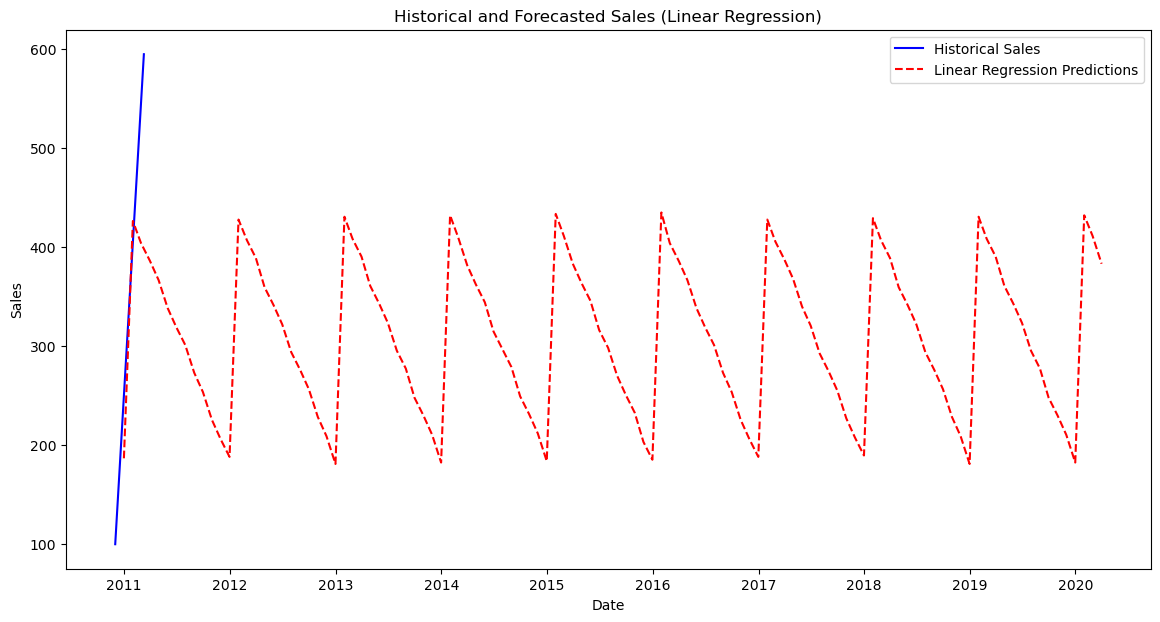

In [137]:
# Prepare the combined future and historical index
future_dates = pd.date_range(start=new_df.index.min(), periods=len(new_df) + 12, freq='M')
combined_data = pd.DataFrame(index=future_dates)
combined_data['Month'] = combined_data.index.month
combined_data['DayOfWeek'] = combined_data.index.dayofweek
combined_data['UnitPrice'] = X['UnitPrice'].mean()  # Assuming constant unit price
combined_data['IsWeekend'] = 0  # Assuming non-weekend for simplicity
combined_data['Country_Encoded'] = X['Country_Encoded'].mode()[0]  # Most frequent or specific value

# Ensure the order of features matches the model's expectations
combined_data = combined_data[['Month', 'DayOfWeek', 'UnitPrice', 'IsWeekend', 'Country_Encoded']]

# Generate predictions for the entire period
lin_sales_predictions = lin_model.predict(combined_data)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(new_df.index, y, label='Historical Sales', color='blue')
plt.plot(future_dates, lin_sales_predictions, label='Linear Regression Predictions', linestyle='--', color='red')
plt.title('Historical and Forecasted Sales (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


### KNN

In [138]:
# Assuming df_monthly is prepared similarly as before
X = df_monthly[['Month', 'DayOfWeek', 'UnitPrice', 'IsWeekend', 'Country_Encoded']]
y = df_monthly['Sales_diff']

# Train the KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X, y)

KNeighborsRegressor()

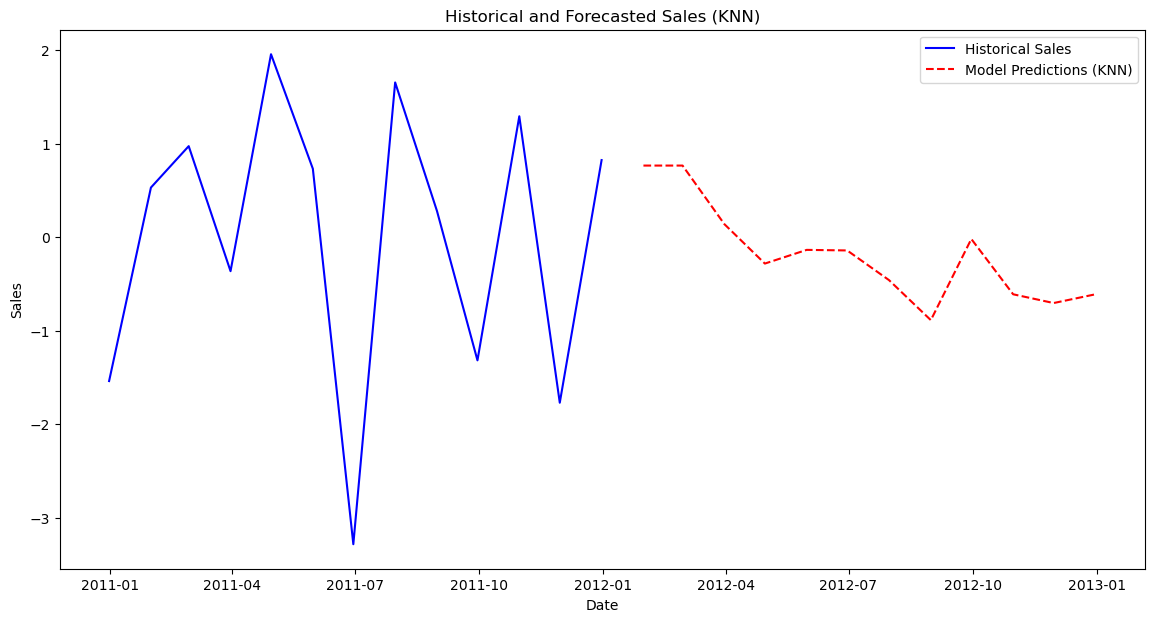

In [139]:
# Use the same starting point for future predictions as in Linear Regression
future_dates = pd.date_range(start=df_monthly['InvoiceDate'].max() + pd.DateOffset(months=1), periods=12, freq='M')
combined_data = pd.DataFrame(index=future_dates)
combined_data['Month'] = combined_data.index.month
combined_data['DayOfWeek'] = combined_data.index.dayofweek
combined_data['UnitPrice'] = df_monthly['UnitPrice'].mean()  # Assuming constant unit price
combined_data['IsWeekend'] = combined_data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
combined_data['Country_Encoded'] = df_monthly['Country_Encoded'].mode()[0]  # Most frequent value

# Generate predictions for the entire period
combined_sales_predictions = knn_model.predict(combined_data)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df_monthly['InvoiceDate'], y, label='Historical Sales', color='blue')
plt.plot(future_dates, combined_sales_predictions, label='Model Predictions (KNN)', linestyle='--', color='red')
plt.title('Historical and Forecasted Sales (KNN)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [140]:
# Assuming new_df is your DataFrame and is already prepared with features
X = new_df[['Month', 'DayOfWeek', 'UnitPrice', 'IsWeekend', 'Country_Encoded']]  # Example features
y = new_df['Sales_diff']  # Target

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)  # You can adjust the number of neighbors (k)
knn_model.fit(X_train, y_train)


KNeighborsRegressor()

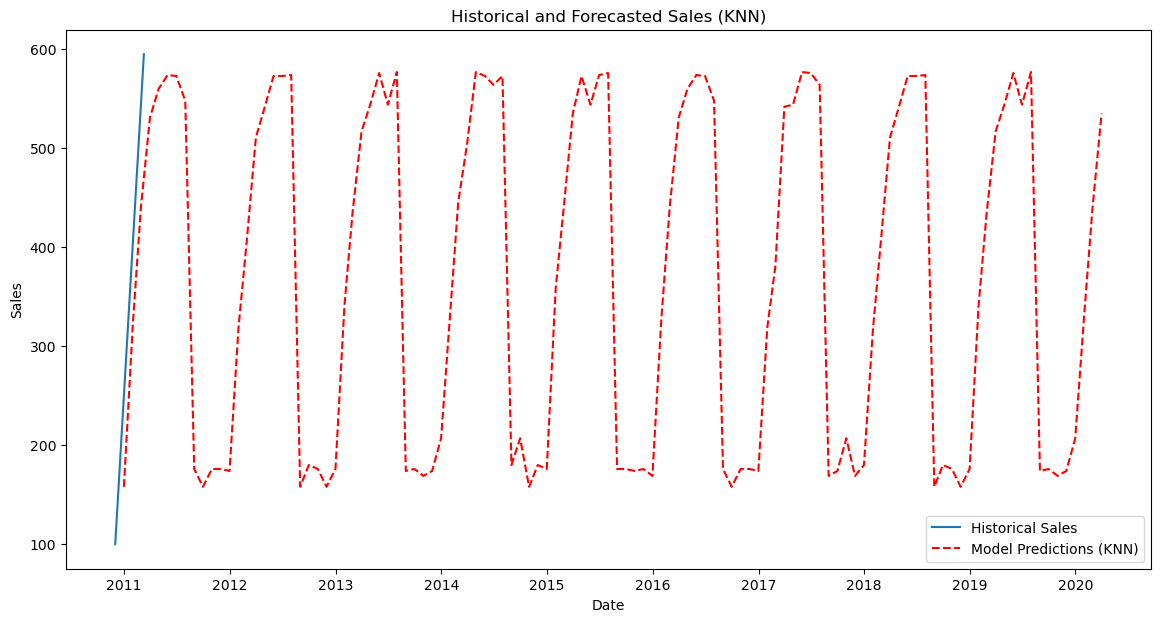

In [141]:
# Prepare the combined future and historical index
future_dates = pd.date_range(start=new_df.index.min(), periods=len(new_df) + 12, freq='M')
combined_data = pd.DataFrame(index=future_dates)
combined_data['Month'] = combined_data.index.month
combined_data['DayOfWeek'] = combined_data.index.dayofweek
combined_data['UnitPrice'] = X['UnitPrice'].mean()  # Assuming constant unit price
combined_data['IsWeekend'] = 0  # Assuming non-weekend for simplicity
combined_data['Country_Encoded'] = X['Country_Encoded'].mode()[0]  # Most frequent or specific value

# Ensure the order of features matches the model's expectations
combined_data = combined_data[['Month', 'DayOfWeek', 'UnitPrice', 'IsWeekend', 'Country_Encoded']]

# Generate predictions for the entire period
combined_sales_predictions = knn_model.predict(combined_data)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(new_df.index, y, label='Historical Sales')
plt.plot(future_dates, combined_sales_predictions, label='Model Predictions (KNN)', linestyle='--', color='red')
plt.title('Historical and Forecasted Sales (KNN)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


### Random Forest

In [142]:
# Assuming df_model is your DataFrame and is already prepared with features
X = df_monthly[['Month', 'DayOfWeek', 'UnitPrice', 'IsWeekend', 'Country_Encoded']]  # Example features
y = df_monthly['Sales_diff']  # Target

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

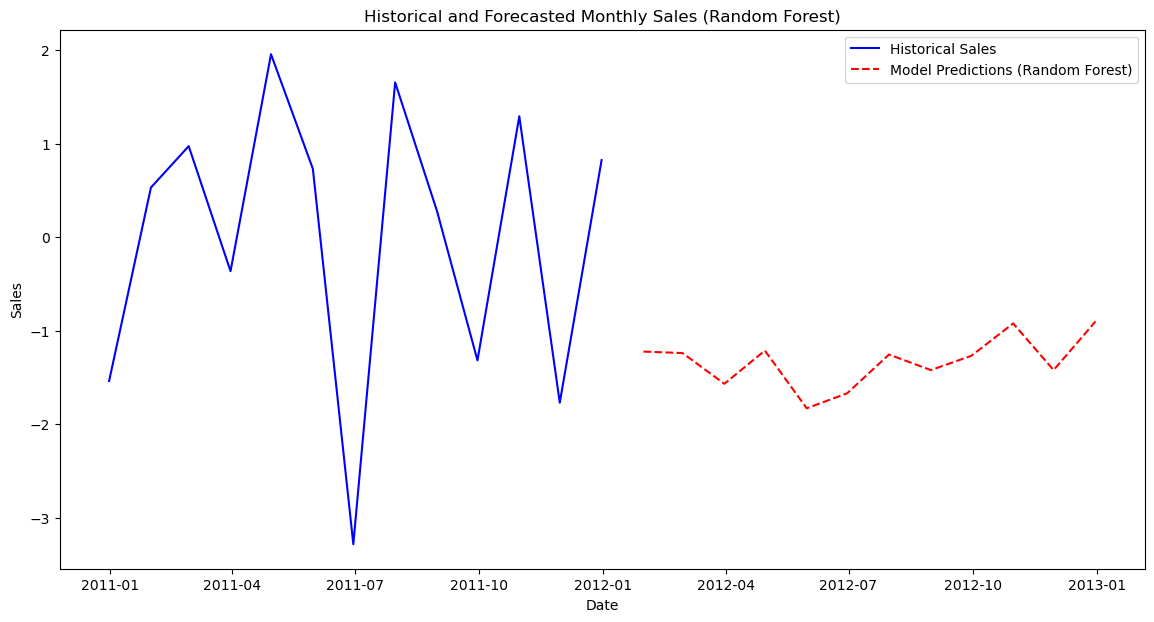

In [143]:
# Preparing the combined future and historical index for forecasting
# Start forecasting from one month after the last recorded month in df_monthly
future_dates = pd.date_range(start=df_monthly['InvoiceDate'].max() + pd.DateOffset(months=1), periods=12, freq='M')
combined_data = pd.DataFrame(index=future_dates)
combined_data['Month'] = combined_data.index.month
combined_data['DayOfWeek'] = combined_data.index.dayofweek
combined_data['UnitPrice'] = df_monthly['UnitPrice'].mean()  # Assuming constant unit price
combined_data['IsWeekend'] = combined_data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
combined_data['Country_Encoded'] = df_monthly['Country_Encoded'].mode()[0]  # Most frequent value

# Ensure the order of features matches the model's expectations
combined_data = combined_data[['Month', 'DayOfWeek', 'UnitPrice', 'IsWeekend', 'Country_Encoded']]

# Generate predictions for the entire period using the trained Random Forest model
combined_sales_predictions = random_forest_model.predict(combined_data)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df_monthly['InvoiceDate'], y, label='Historical Sales', color='blue')
plt.plot(future_dates, combined_sales_predictions, label='Model Predictions (Random Forest)', linestyle='--', color='red')
plt.title('Historical and Forecasted Monthly Sales (Random Forest)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [144]:
# Assuming new_df is your DataFrame and is already prepared with features
X = new_df[['Month', 'DayOfWeek', 'UnitPrice', 'IsWeekend', 'Country_Encoded']]  # Example features
y = new_df['Sales_diff']  # Target

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)



RandomForestRegressor(random_state=42)

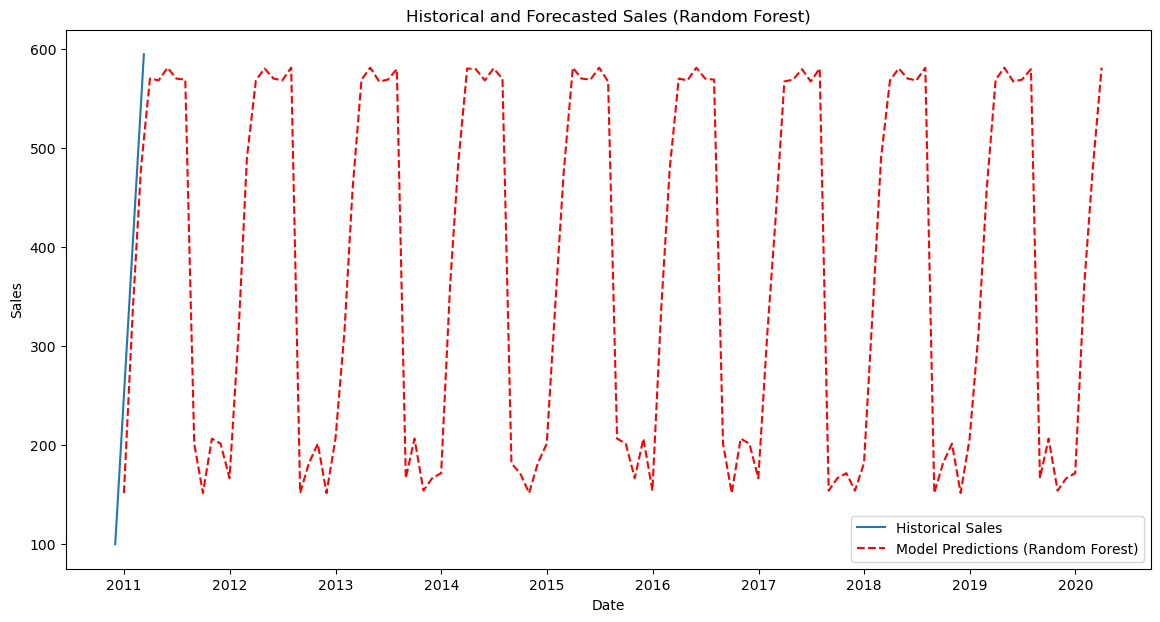

In [145]:
# Prepare the combined future and historical index
future_dates = pd.date_range(start=new_df.index.min(), periods=len(new_df) + 12, freq='M')
combined_data = pd.DataFrame(index=future_dates)
combined_data['Month'] = combined_data.index.month
combined_data['DayOfWeek'] = combined_data.index.dayofweek
combined_data['UnitPrice'] = X['UnitPrice'].mean()  # Assuming constant unit price
combined_data['IsWeekend'] = 0  # Assuming non-weekend for simplicity
combined_data['Country_Encoded'] = X['Country_Encoded'].mode()[0]  # Most frequent or specific value

# Ensure the order of features matches the model's expectations
combined_data = combined_data[['Month', 'DayOfWeek', 'UnitPrice', 'IsWeekend', 'Country_Encoded']]

# Generate predictions for the entire period
combined_sales_predictions = random_forest_model.predict(combined_data)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(new_df.index, y, label='Historical Sales')
plt.plot(future_dates, combined_sales_predictions, label='Model Predictions (Random Forest)', linestyle='--', color='red')
plt.title('Historical and Forecasted Sales (Random Forest)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


### XGBoost 

In [146]:
# Prepare features and target from the same dataset
X = df_monthly[['Month', 'DayOfWeek', 'UnitPrice', 'IsWeekend', 'Country_Encoded']]  # Example features
y = df_monthly['Sales_diff']  # Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBRegressor model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

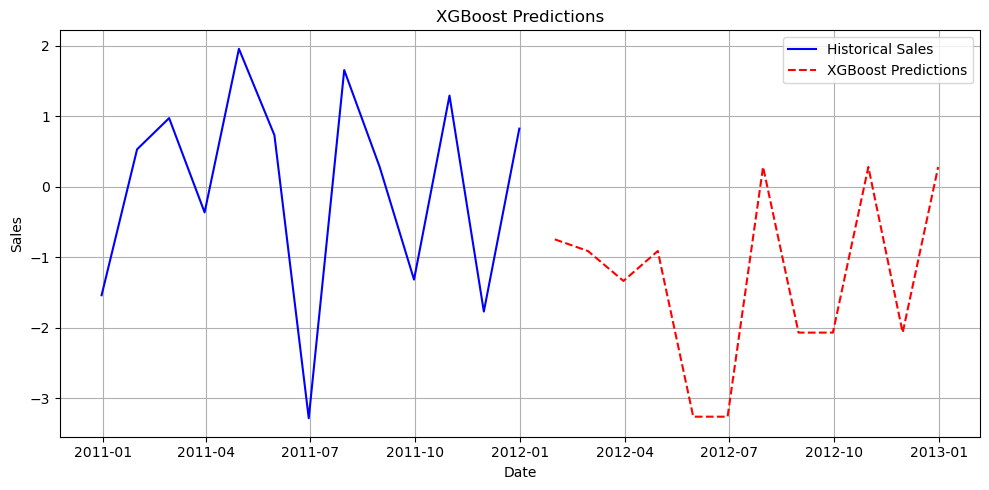

In [147]:
# Prepare future dates for forecasting
future_dates = pd.date_range(start=df_monthly['InvoiceDate'].max() + pd.DateOffset(months=1), periods=12, freq='M')
combined_data = pd.DataFrame(index=future_dates)
combined_data['Month'] = combined_data.index.month
combined_data['DayOfWeek'] = combined_data.index.dayofweek
combined_data['UnitPrice'] = df_monthly['UnitPrice'].mean()  # Ensure this uses the correct DataFrame
combined_data['IsWeekend'] = combined_data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
combined_data['Country_Encoded'] = df_monthly['Country_Encoded'].mode()[0]  # Ensure this uses the correct DataFrame

# Generating predictions from XGBoost model
xgb_predictions = xgb_model.predict(combined_data)

# Plotting
plt.figure(figsize=(10, 5))  # Adjust figure size to your preference
plt.plot(df_monthly['InvoiceDate'], y, label='Historical Sales', color='blue')
plt.plot(future_dates, xgb_predictions, label='XGBoost Predictions', linestyle='--', color='red')
plt.title('XGBoost Predictions')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)  # Optionally add grid for better readability
plt.tight_layout()
plt.show()


In [148]:
# Assuming new_df is your DataFrame and is already prepared with features
X = new_df[['Month', 'DayOfWeek', 'UnitPrice', 'IsWeekend', 'Country_Encoded']]  # Example features
y = new_df['Sales_diff']  # Target

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

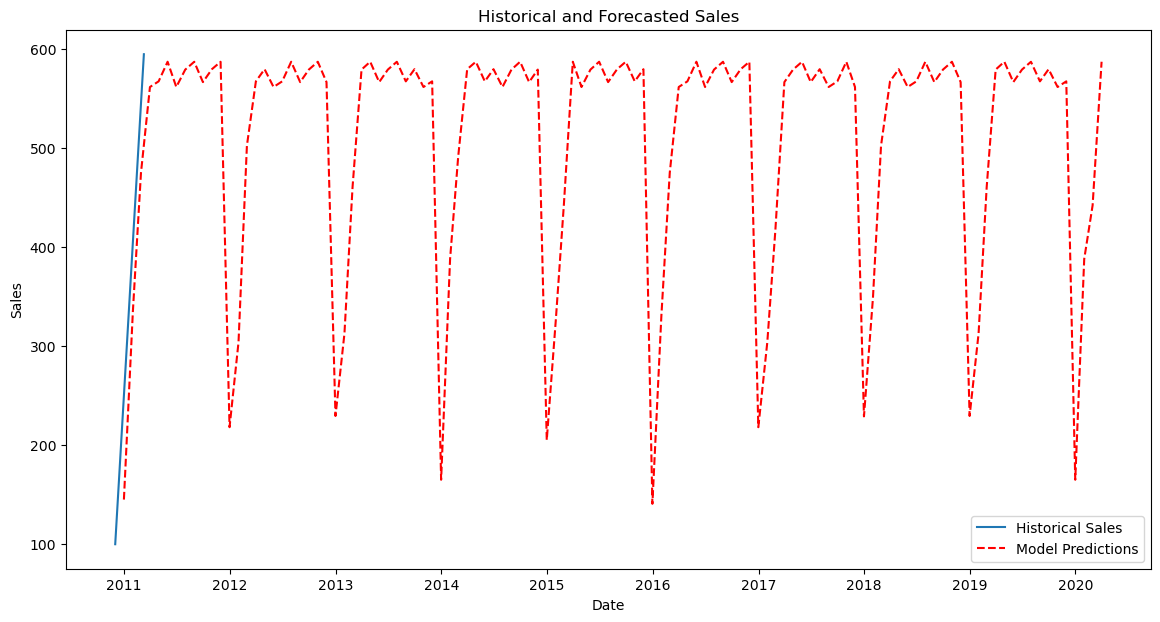

In [149]:
# Prepare the combined future and historical index
future_dates = pd.date_range(start=new_df.index.min(), periods=len(new_df) + 12, freq='M')
combined_data = pd.DataFrame(index=future_dates)
combined_data['Month'] = combined_data.index.month
combined_data['DayOfWeek'] = combined_data.index.dayofweek
combined_data['UnitPrice'] = X['UnitPrice'].mean()  # Assuming constant unit price
combined_data['IsWeekend'] = 0  # Assuming non-weekend for simplicity
combined_data['Country_Encoded'] = X['Country_Encoded'].mode()[0]  # Most frequent or specific value

# Ensure the order of features matches the model's expectations
combined_data = combined_data[['Month', 'DayOfWeek', 'UnitPrice', 'IsWeekend', 'Country_Encoded']]

# Generate predictions for the entire period
combined_sales_predictions = model.predict(combined_data)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(new_df.index, y, label='Historical Sales')
plt.plot(future_dates, combined_sales_predictions, label='Model Predictions', linestyle='--', color='red')
plt.title('Historical and Forecasted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


### Decision Trees Algorithm

In [150]:
# Assuming df_monthly is your DataFrame and is already prepared with features
X = df_monthly[['Month', 'DayOfWeek', 'UnitPrice', 'IsWeekend', 'Country_Encoded']]  # Example features
y = df_monthly['Sales_diff']  # Target

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Decision Tree model
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

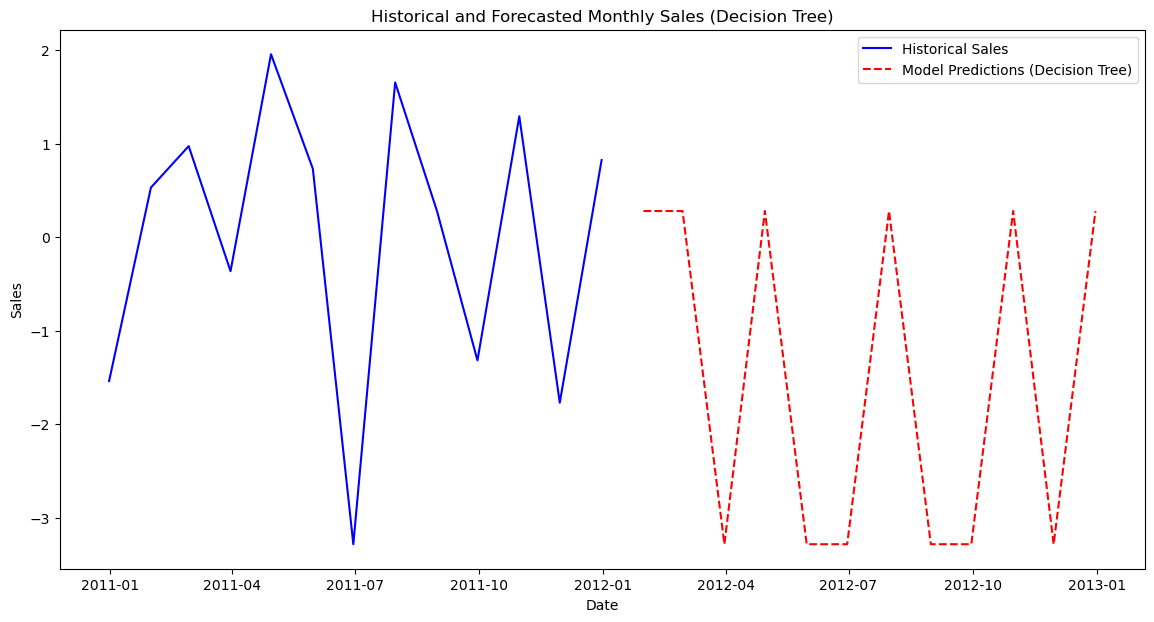

In [151]:
# Start forecasting from one month after the last recorded month in df_monthly
future_dates = pd.date_range(start=df_monthly['InvoiceDate'].max() + pd.DateOffset(months=1), periods=12, freq='M')
combined_data = pd.DataFrame(index=future_dates)
combined_data['Month'] = combined_data.index.month
combined_data['DayOfWeek'] = combined_data.index.dayofweek
combined_data['UnitPrice'] = X['UnitPrice'].mean()  # Assuming constant unit price
combined_data['IsWeekend'] = 0  # Assuming non-weekend for simplicity
combined_data['Country_Encoded'] = X['Country_Encoded'].mode()[0]  # Most frequent or specific value

# Ensure the order of features matches the model's expectations
combined_data = combined_data[['Month', 'DayOfWeek', 'UnitPrice', 'IsWeekend', 'Country_Encoded']]

# Generate predictions for the entire period
combined_sales_predictions = decision_tree_model.predict(combined_data)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df_monthly['InvoiceDate'], y, label='Historical Sales', color='blue')
plt.plot(future_dates, combined_sales_predictions, label='Model Predictions (Decision Tree)', linestyle='--', color='red')
plt.title('Historical and Forecasted Monthly Sales (Decision Tree)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [152]:
# Assuming new_df is your DataFrame and is already prepared with features
X = new_df[['Month', 'DayOfWeek', 'UnitPrice', 'IsWeekend', 'Country_Encoded']]  # Example features
y = new_df['Sales_diff']  # Target

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Decision Tree model
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)


DecisionTreeRegressor(random_state=42)

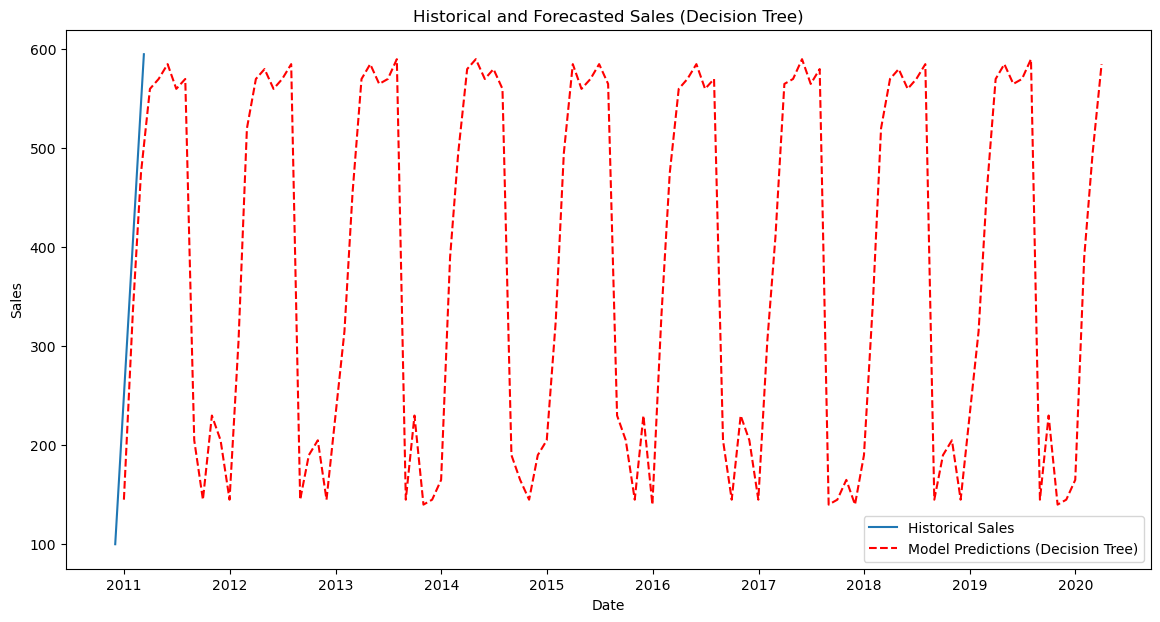

In [153]:
# Prepare the combined future and historical index
future_dates = pd.date_range(start=new_df.index.min(), periods=len(new_df) + 12, freq='M')
combined_data = pd.DataFrame(index=future_dates)
combined_data['Month'] = combined_data.index.month
combined_data['DayOfWeek'] = combined_data.index.dayofweek
combined_data['UnitPrice'] = X['UnitPrice'].mean()  # Assuming constant unit price
combined_data['IsWeekend'] = 0  # Assuming non-weekend for simplicity
combined_data['Country_Encoded'] = X['Country_Encoded'].mode()[0]  # Most frequent or specific value

# Ensure the order of features matches the model's expectations
combined_data = combined_data[['Month', 'DayOfWeek', 'UnitPrice', 'IsWeekend', 'Country_Encoded']]

# Generate predictions for the entire period
combined_sales_predictions = decision_tree_model.predict(combined_data)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(new_df.index, y, label='Historical Sales')
plt.plot(future_dates, combined_sales_predictions, label='Model Predictions (Decision Tree)', linestyle='--', color='red')
plt.title('Historical and Forecasted Sales (Decision Tree)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


### Neural Network

In [154]:
# Assuming df_monthly is your DataFrame and is already prepared with features
X = df_monthly[['Month', 'DayOfWeek', 'UnitPrice', 'IsWeekend', 'Country_Encoded']]  # Example features
y = df_monthly['Sales_diff']  # Target

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Neural Network model
neural_network_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
neural_network_model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

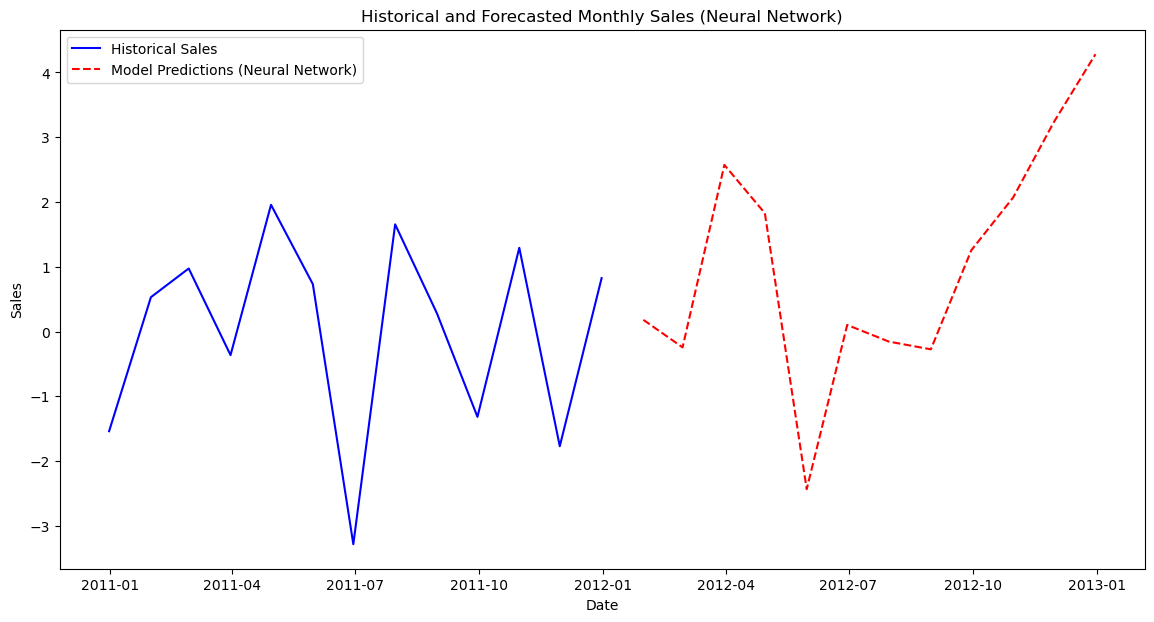

In [155]:
# Start forecasting from one month after the last recorded month in df_monthly
future_dates = pd.date_range(start=df_monthly['InvoiceDate'].max() + pd.DateOffset(months=1), periods=12, freq='M')
combined_data = pd.DataFrame(index=future_dates)
combined_data['Month'] = combined_data.index.month
combined_data['DayOfWeek'] = combined_data.index.dayofweek
combined_data['UnitPrice'] = df_monthly['UnitPrice'].mean()  # Assuming constant unit price
combined_data['IsWeekend'] = combined_data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
combined_data['Country_Encoded'] = df_monthly['Country_Encoded'].mode()[0]  # Most frequent value

# Ensure the order of features matches the model's expectations
combined_data = combined_data[['Month', 'DayOfWeek', 'UnitPrice', 'IsWeekend', 'Country_Encoded']]

# Generate predictions for the entire period
combined_sales_predictions = neural_network_model.predict(combined_data)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df_monthly['InvoiceDate'], y, label='Historical Sales', color='blue')
plt.plot(future_dates, combined_sales_predictions, label='Model Predictions (Neural Network)', linestyle='--', color='red')
plt.title('Historical and Forecasted Monthly Sales (Neural Network)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [156]:
# Assuming new_df is your DataFrame and is already prepared with features
X = new_df[['Month', 'DayOfWeek', 'UnitPrice', 'IsWeekend', 'Country_Encoded']]  # Example features
y = new_df['Sales_diff']  # Target

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Neural Network model
neural_network_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
neural_network_model.fit(X_train, y_train)


/Users/yapjh/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.



MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

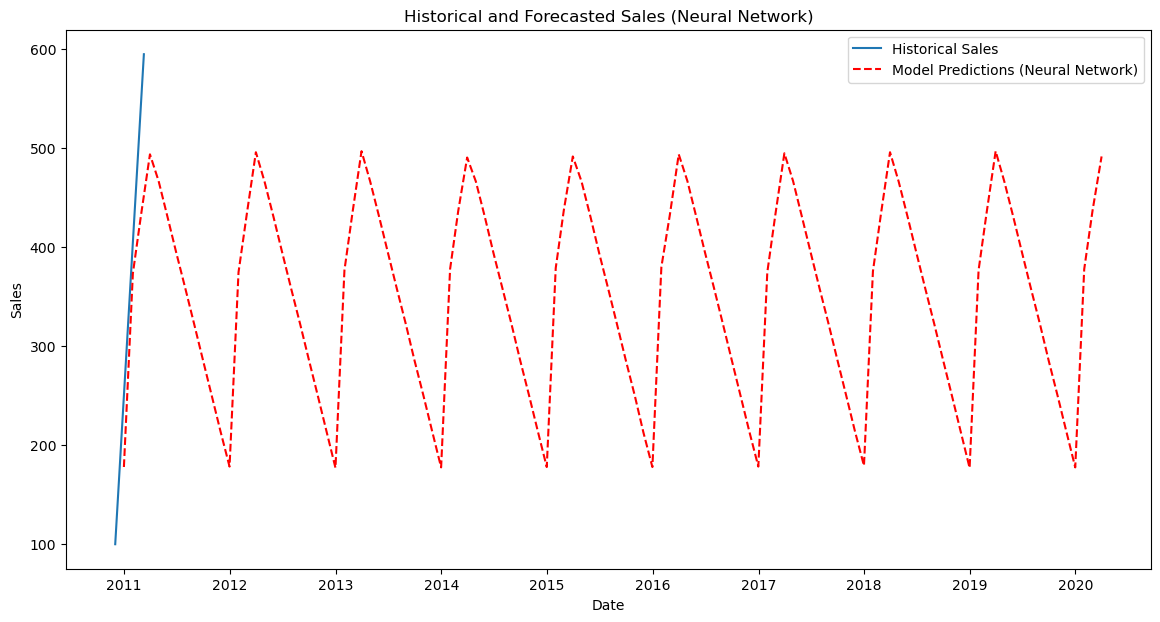

In [157]:
# Prepare the combined future and historical index
future_dates = pd.date_range(start=new_df.index.min(), periods=len(new_df) + 12, freq='M')
combined_data = pd.DataFrame(index=future_dates)
combined_data['Month'] = combined_data.index.month
combined_data['DayOfWeek'] = combined_data.index.dayofweek
combined_data['UnitPrice'] = X['UnitPrice'].mean()  # Assuming constant unit price
combined_data['IsWeekend'] = 0  # Assuming non-weekend for simplicity
combined_data['Country_Encoded'] = X['Country_Encoded'].mode()[0]  # Most frequent or specific value

# Ensure the order of features matches the model's expectations
combined_data = combined_data[['Month', 'DayOfWeek', 'UnitPrice', 'IsWeekend', 'Country_Encoded']]

# Generate predictions for the entire period
combined_sales_predictions = neural_network_model.predict(combined_data)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(new_df.index, y, label='Historical Sales')
plt.plot(future_dates, combined_sales_predictions, label='Model Predictions (Neural Network)', linestyle='--', color='red')
plt.title('Historical and Forecasted Sales (Neural Network)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


                        MAE       MSE      RMSE          R²
KNN                1.695513  2.908964  1.705569  -84.055375
Linear Regression  1.852414  3.984298  1.996071 -115.497137
Decision Tree      2.335318  5.475723  2.340026 -159.104986
Random Forest      2.233161  5.052702  2.247822 -146.736256
Neural Network     0.899121  1.351850  1.162691  -38.526809


/Users/yapjh/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



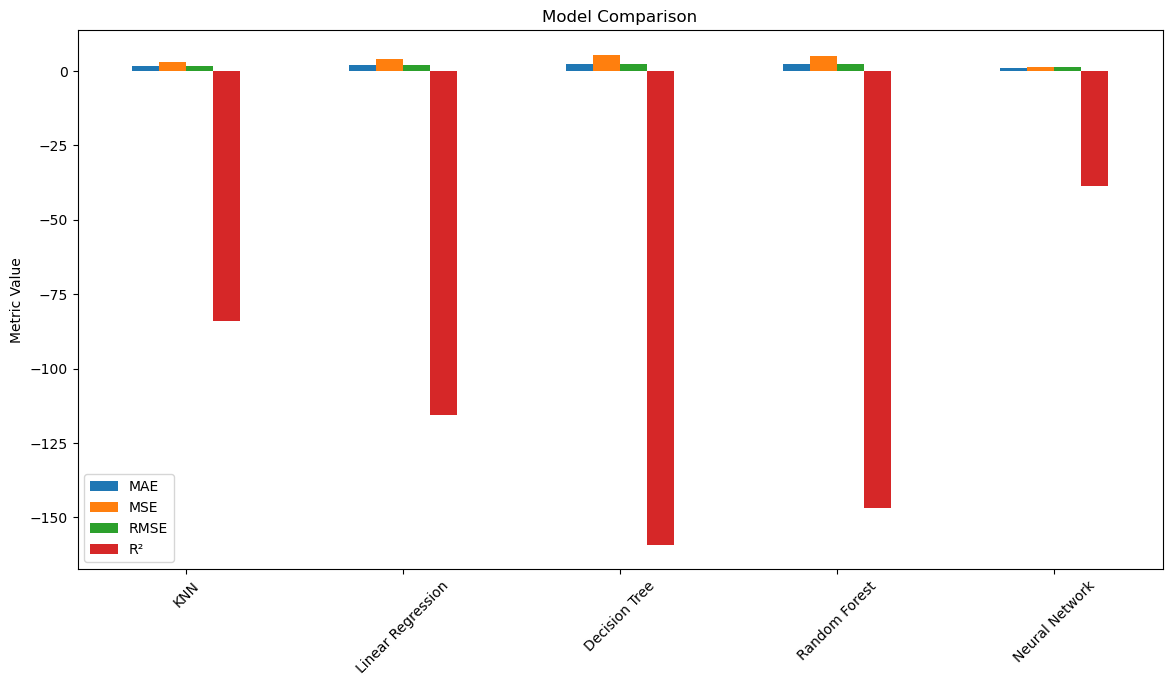

In [158]:
# Assuming df_monthly is your DataFrame and is already prepared with features
X = df_monthly[['Month', 'DayOfWeek', 'UnitPrice', 'IsWeekend', 'Country_Encoded']]  # Example features
y = df_monthly['Sales_diff']  # Target

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(n_estimators=100),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

# Dictionary to hold evaluation metrics
evaluation_results = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    evaluation_results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    }

# Convert results to DataFrame for better visualization
evaluation_df = pd.DataFrame(evaluation_results).T
print(evaluation_df)

# Plotting the results
evaluation_df[['MAE', 'MSE', 'RMSE', 'R²']].plot(kind='bar', figsize=(14, 7))
plt.title('Model Comparison')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.show()


                          MAE           MSE        RMSE        R²
KNN                 55.950000   4590.950000   67.756549  0.770839
Linear Regression   86.528403  10298.632715  101.482179  0.485936
Decision Tree       69.750000   5741.250000   75.771037  0.713421
Random Forest       53.915417   3699.526272   60.823731  0.815335
Neural Network     158.802683  33929.845558  184.200558 -0.693634


/Users/yapjh/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



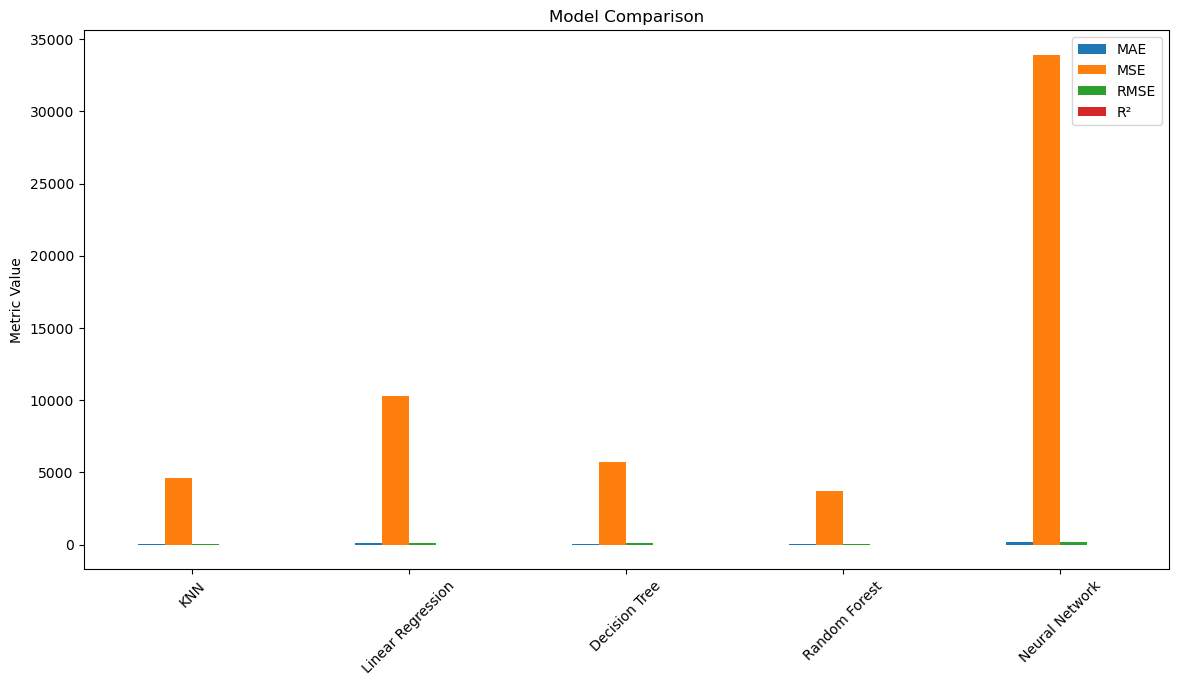

In [159]:
# Assuming new_df is your DataFrame and is already prepared with features
X = new_df[['Month', 'DayOfWeek', 'UnitPrice', 'IsWeekend', 'Country_Encoded']]  # Example features
y = new_df['Sales_diff']  # Target

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(n_estimators=100),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

# Dictionary to hold evaluation metrics
evaluation_results = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    evaluation_results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    }

# Convert results to DataFrame for better visualization
evaluation_df = pd.DataFrame(evaluation_results).T
print(evaluation_df)

# Plotting the results
evaluation_df[['MAE', 'MSE', 'RMSE', 'R²']].plot(kind='bar', figsize=(14, 7))
plt.title('Model Comparison')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.show()
